In [1]:
import os
import requests
import shapely
import json

# !pip install pydotplus
from sklearn import tree
# from IPython.display import Image  
# import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pylab


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['linalg', 'Polygon']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:]
    indices = np.argsort(importances)[::-1]
    #std = np.std([tree.feature_importances_ for tree in rf.estimators_],
    #         axis=0)

    pl.figure(figsize=(16,16))
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", #yerr=std[indices]
           align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
#featureImportancePlot(rf, X_foursquare.columns)

## Data Processing

This section combines the raw dataset with the typology and NYC shape file

In [3]:
twitter = pd.read_csv('Data/NYtwitter_output_12_17.csv')

In [4]:
NYCzip = gpd.read_file('shape7/region.shp')

In [5]:
typ = pd.read_excel('Data/NY final data for typologies 1.19.19.xlsx')

In [6]:
typ['Type_1.19'].replace('MHI - Advanced Exclusion', 'MHI - Ongoing Exclusion', inplace=True)

In [7]:
NYCzip['geojoin']=NYCzip['geoid'].astype(float)

In [8]:
#alldata = twitter.merge(typ, right_on="geoid", left_on="tract")

In [9]:
addlcensus = pd.read_stata('Data/UDP_NYC_Variables.dta')

In [10]:
addlcensus['geojoinaddl']=addlcensus['GEOid2'].astype(float)

In [11]:
alldata = typ.merge(addlcensus[['TOD', 'geojoinaddl']], right_on='geojoinaddl', left_on= 'geoid')

In [12]:
fulldataset = NYCzip.merge(alldata, right_on="geoid", left_on="geojoin")

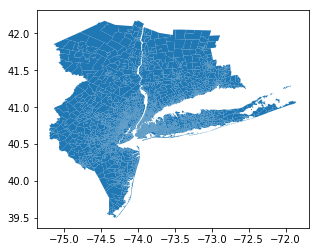

In [13]:
fulldataset.plot()

In [14]:
#creating twitter metrics
twitter["localpercentage"]=twitter.local_tweets/twitter.total_tweets
twitter["nbrpercentage"]=twitter.neighbor_tweets/twitter.total_tweets
twitter["visitorpercentage"]=twitter.other_tweets/twitter.total_tweets

In [15]:
fulldataset.shape

(5290, 125)

MHI - Stable or Early Stage of Exclusion              2004
MHI - Ongoing Exclusion                                762
LI - At Risk of Gentrification                         522
LI - Not Losing Low-Income Households                  482
LI - Ongoing Displacement of Low-Income Households     463
MHI - Advanced Gentrification                          370
VHI - Super Gentrification or Exclusion                314
LI - Ongoing Gentrification                            275
Missing Data                                            98
Name: Type_1.19, dtype: int64

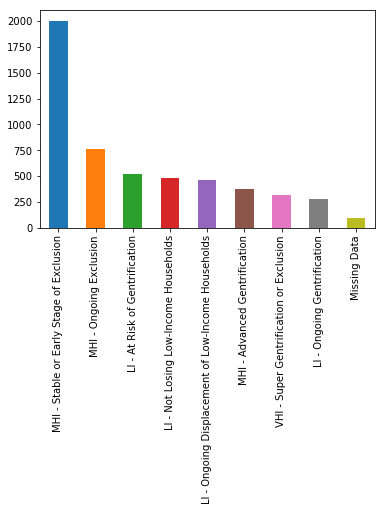

In [16]:
#checking merge results 
fulldataset['Type_1.19'].value_counts().plot(kind='bar')
fulldataset['Type_1.19'].value_counts()

In [17]:
#creating binary typology
fulldataset['Type_binary'] = fulldataset['Type_1.19'].copy()
fulldataset['Type_binary'].replace('VHI - Super Gentrification or Exclusion',0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
fulldataset['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
fulldataset['Type_binary'].replace('LI - At Risk of Gentrification',0,inplace=True)
fulldataset['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
fulldataset['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
fulldataset['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
fulldataset['Type_binary'].replace('Missing Data',0,inplace=True)
fulldataset['Type_binary'].replace(nan,0,inplace=True)

The percent of non-gentrifying is:0.878072


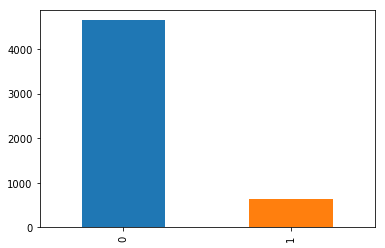

In [18]:
fulldataset['Type_binary'].value_counts().plot(kind='bar')
fulldataset['Type_binary'].value_counts()
print('The percent of non-gentrifying is:%f'%(fulldataset[fulldataset['Type_binary'] == 0]['geoid_x'].count()/fulldataset['geoid_x'].count()))

In [19]:
binaries = pd.read_csv('Data/NEW_6_BINARIES_ALL.csv', index_col=0)

In [21]:
fulldataset.shape

(5290, 126)

In [22]:
fulldataset = fulldataset.merge(binaries, right_on= 'GEOID', left_on='geojoin')

In [23]:
binaries.columns

Index(['pct_ch_percol00_16_binary', 'pct_ch_hinc00_16_binary',
       'pct_ch_medhval00_16_binary', 'pct_ch_medrent00_16_binary',
       'Ongoing_adv_gent', 'gent00_16', 'gent90_00', 'Supergent16', 'GEOID'],
      dtype='object')

Some tracts drop off due to NULL values in critical fields for the development of the binary dependent variables (~450)

In [24]:
## Adding new census data here 
newcen00 = pd.read_csv('Data/tract00_feature.csv', index_col=0)
newcen00['geojoin']=newcen00['geoid'].astype(float)
newcen00subset = newcen00[['geoid', 'geojoin','pop00', 'phisp00', 'pnhblk00', 'pasian00', 'popden00', 'unempden00', 'pag25up00']]

In [25]:
##adding the new census features
fulldataset = fulldataset.merge(newcen00subset, right_on='geojoin', left_on='geojoin')

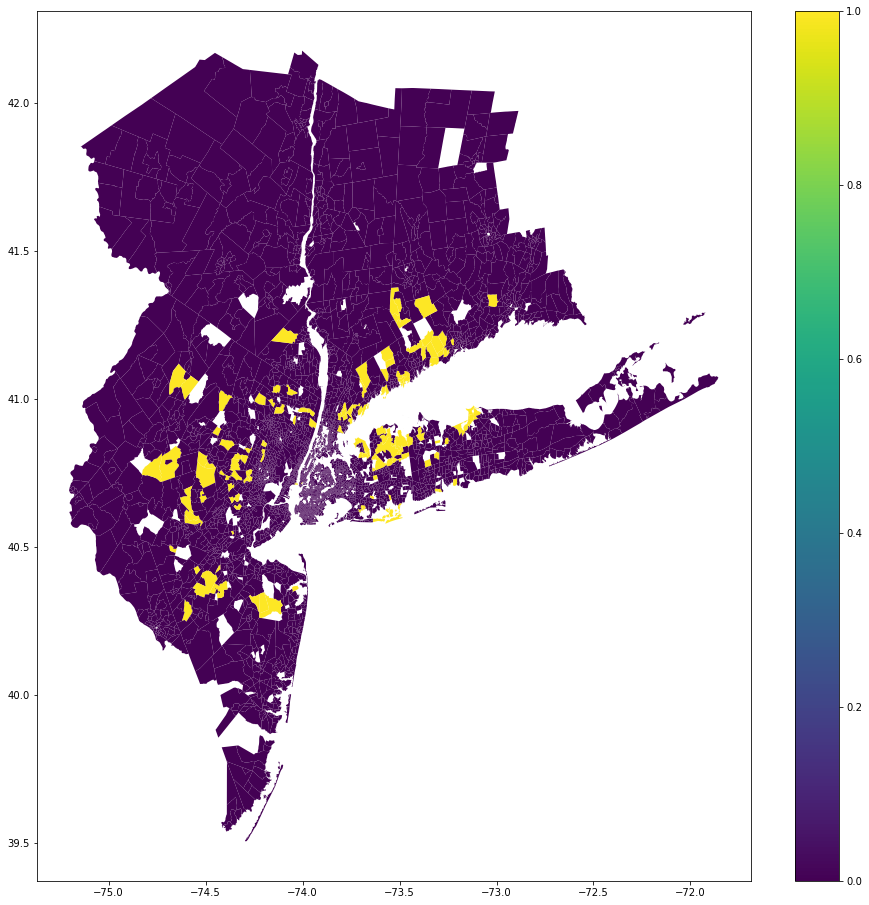

In [26]:
f, ax = plt.subplots(figsize=(16,16))
fulldataset.plot(column='Supergent16', ax=ax, legend=True)

# Modelling the Census Data as a baseline

We will use a subset of the features used to create the original typologies as a baseline

In [27]:
censussubset = fulldataset[['medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
   # new census features
  'pop00_y', 
  'phisp00',
  'pnhblk00', 
  'pasian00', 
 'popden00',
  'unempden00', 
  'pag25up00',
  'Type_binary',
 'pct_ch_hinc00_16_binary',
 'pct_ch_percol00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [28]:
censussubset.shape

(4829, 22)

In [29]:
censussubset = censussubset.dropna()

In [30]:
censussubset.shape

(4829, 22)

In [31]:
censusmodeldata=censussubset.iloc[:, 0:-7]

In [32]:
cols = ['featureset', 'binaryvariable', 'modeltype', 'f1score']
resultsdf = pd.DataFrame(columns=cols, index=range(1))

In [95]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target', ]
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_percol00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
resdict = []
print('[TN, FP][FN, TP]')
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    clf2 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf2.score(modeldata_train, modeltarget_train)
    testscore = clf2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, clf2.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, clf2.predict(modeldata2)) )
    #featureImportancePlot(clf2, modeldata2.columns)
    resdict.append({'featureset': 'censusonly', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.871301775148 testscore:  0.890269151139 F1:  0.0 
 [[4235    0]
 [ 594    0]]
people_target trainscore:  0.887573964497 testscore:  0.890269151139 F1:  0.0124223602484 
 [[4288    1]
 [ 538    2]]
people2_target trainscore:  0.929585798817 testscore:  0.924085576259 F1:  0.285714285714 
 [[4377   59]
 [ 289  104]]
place1_target trainscore:  0.943786982249 testscore:  0.945479641132 F1:  0.288288288288 
 [[4485   42]
 [ 227   75]]
place2_target trainscore:  0.907100591716 testscore:  0.895100069013 F1:  0.0 
 [[4352    1]
 [ 465   11]]
gent16_target trainscore:  0.918047337278 testscore:  0.913043478261 F1:  0.388349514563 
 [[4252  195]
 [ 208  174]]
supergent_target trainscore:  0.984023668639 testscore:  0.979296066253 F1:  0.634146341463 
 [[4633   62]
 [  22  112]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target', ]
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_percol00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    logit_2 = LogisticRegression(C = 10000)
    logit_2.fit(modeldata_train, modeltarget_train)   
    trainscore = logit_2.score(modeldata_train, modeltarget_train)
    testscore = logit_2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, logit_2.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, logit_2.predict(modeldata2)) )
    #featureImportancePlot(clf2, modeldata2.columns)
    resdict.append({'featureset': 'censusonly', 'binaryvariable': targetnames[a], 'modeltype': 'logit', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870118343195 testscore:  0.889579020014 F1:  0.0243902439024 
 [[4224   11]
 [ 588    6]]
people_target trainscore:  0.886390532544 testscore:  0.893719806763 F1:  0.18085106383 
 [[4240   49]
 [ 489   51]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

people2_target trainscore:  0.915976331361 testscore:  0.926846100759 F1:  0.15873015873 
 [[4407   29]
 [ 361   32]]
place1_target trainscore:  0.933727810651 testscore:  0.946169772257 F1:  0.204081632653 
 [[4498   29]
 [ 273   29]]
place2_target trainscore:  0.904142011834 testscore:  0.894409937888 F1:  0.0 
 [[4349    4]
 [ 473    3]]
gent16_target trainscore:  0.917455621302 testscore:  0.928916494134 F1:  0.0 
 [[4447    0]
 [ 382    0]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

supergent_target trainscore:  0.967159763314 testscore:  0.975155279503 F1:  0.1 
 [[4676   19]
 [ 128    6]]


[TN, FP][FN, TP]
binary trainscore:  0.871301775148 testscore:  0.890269151139 F1:  0.0 
 [[4235    0]
 [ 594    0]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


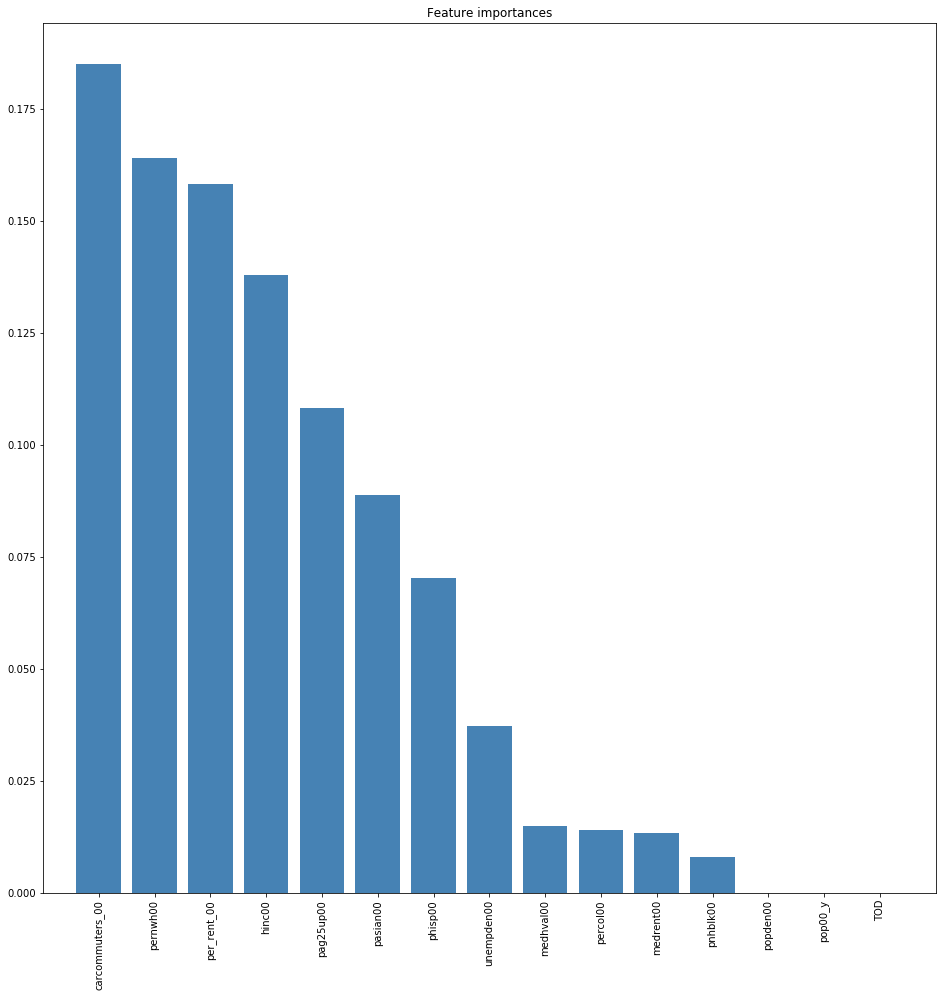

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


people_target trainscore:  0.887573964497 testscore:  0.890269151139 F1:  0.0 
 [[4289    0]
 [ 539    1]]


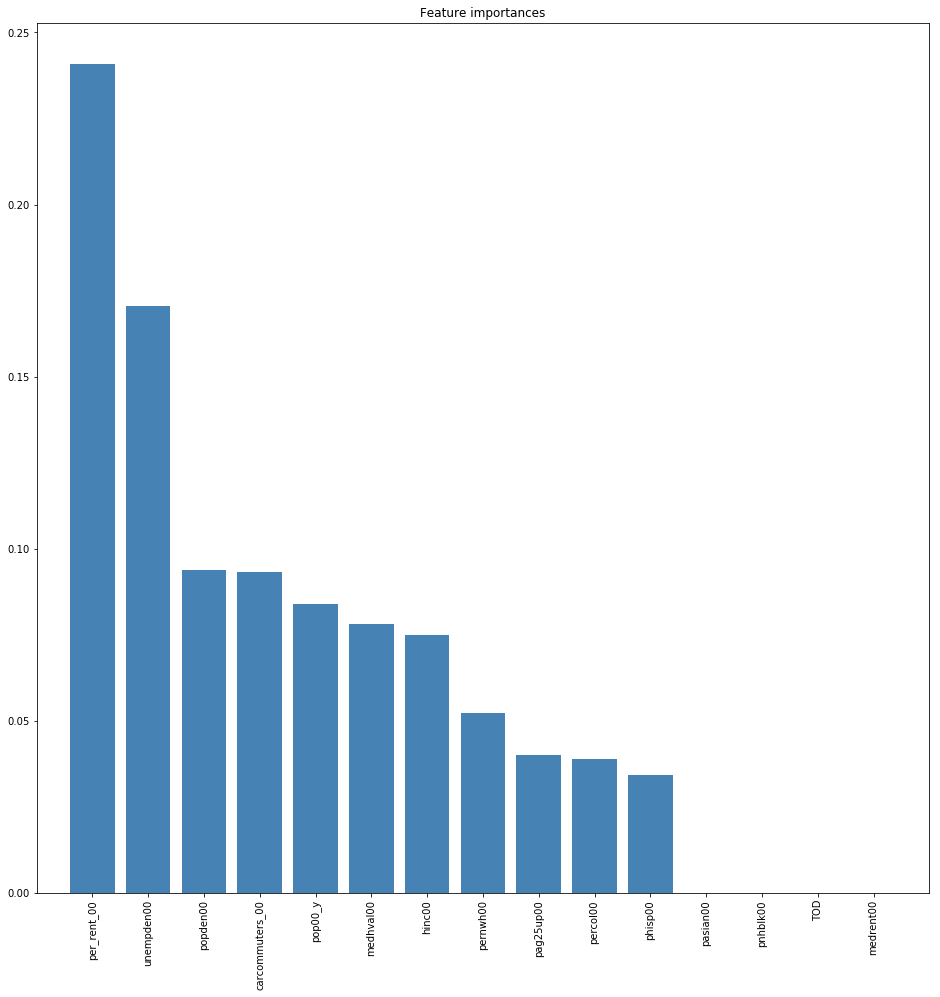

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


people2_target trainscore:  0.919822485207 testscore:  0.926155969634 F1:  0.115702479339 
 [[4431    5]
 [ 373   20]]


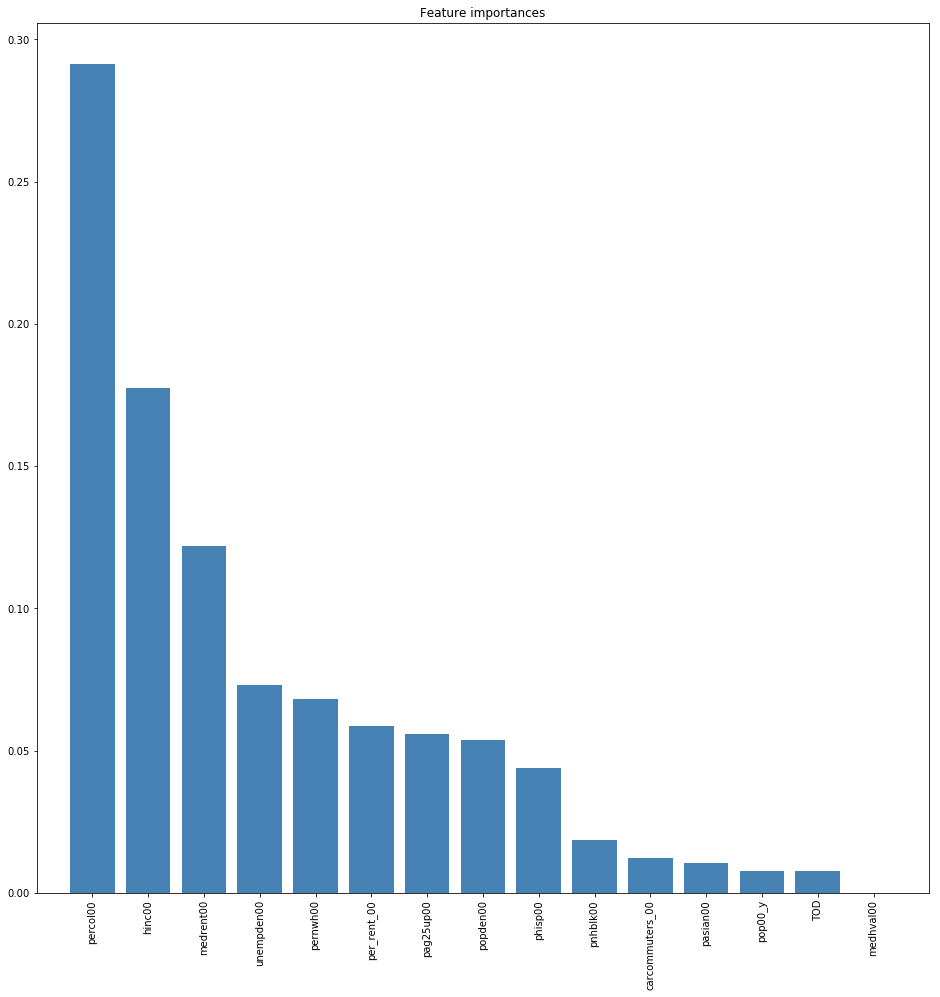

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


place1_target trainscore:  0.936686390533 testscore:  0.947550034507 F1:  0.116279069767 
 [[4525    2]
 [ 288   14]]


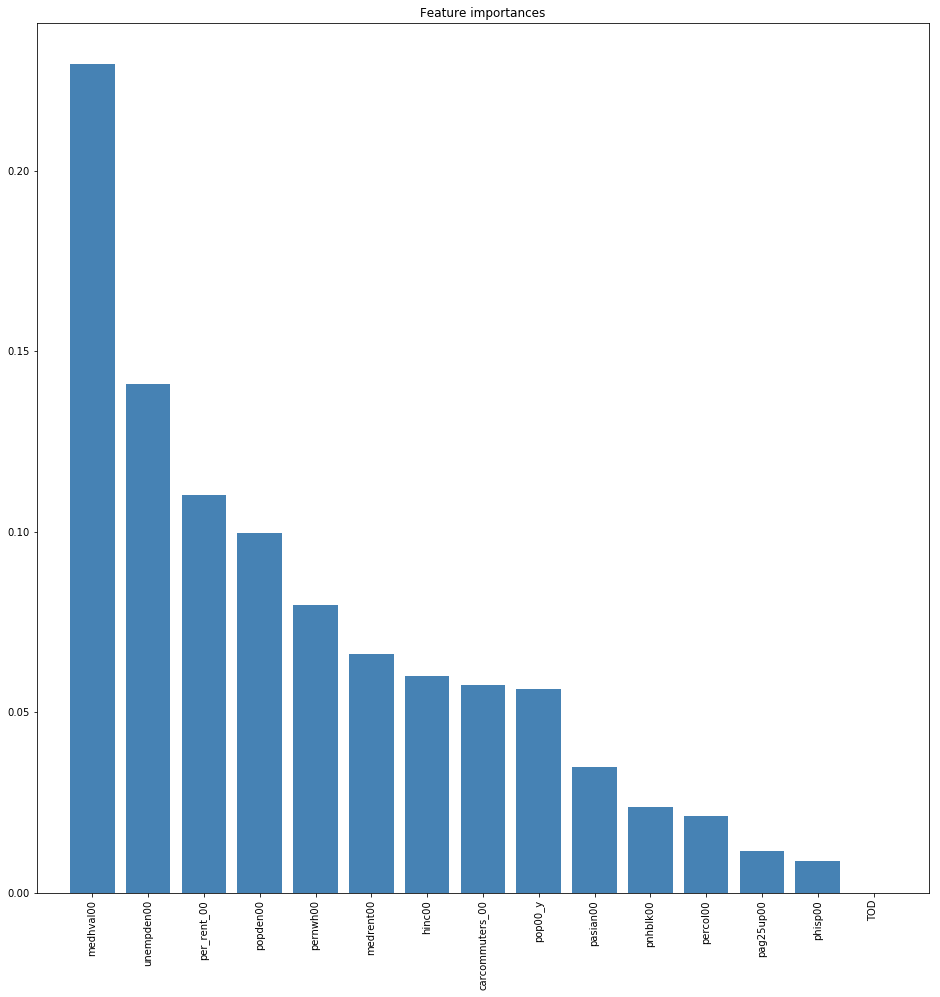

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


place2_target trainscore:  0.903846153846 testscore:  0.895790200138 F1:  0.0 
 [[4353    0]
 [ 476    0]]


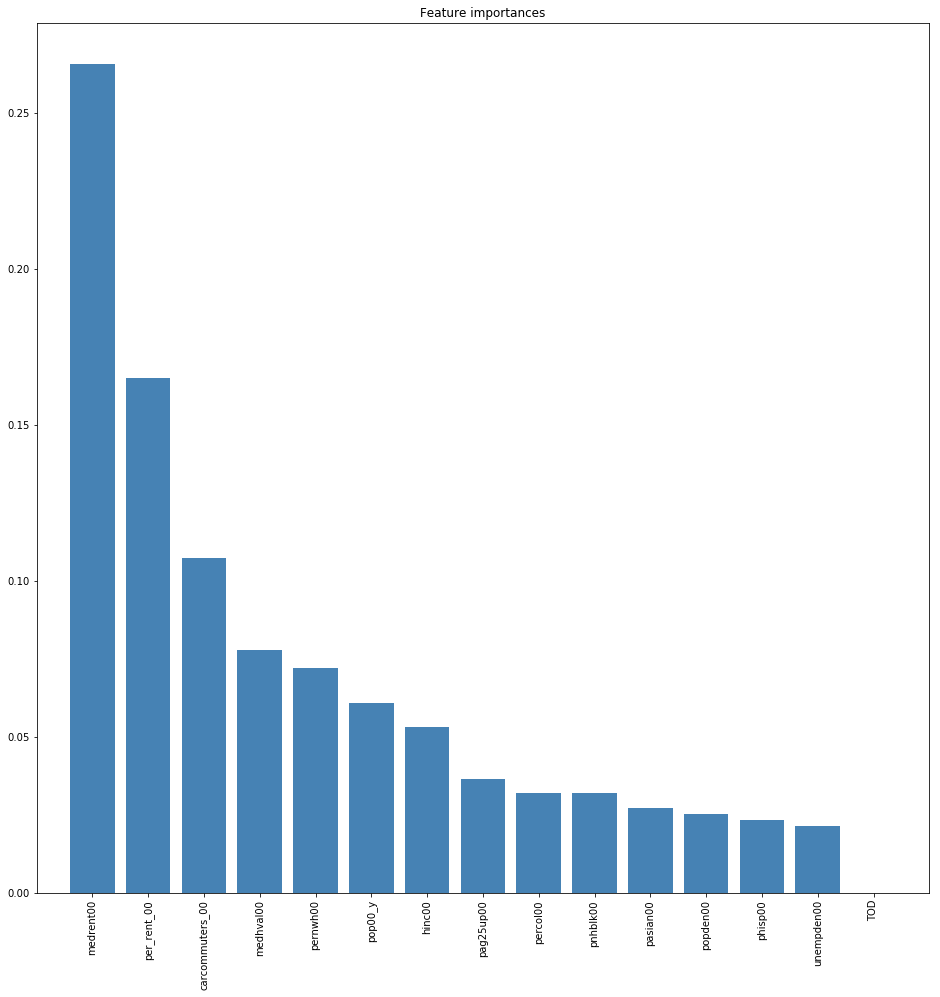

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


gent16_target trainscore:  0.918639053254 testscore:  0.928916494134 F1:  0.0 
 [[4447    0]
 [ 378    4]]


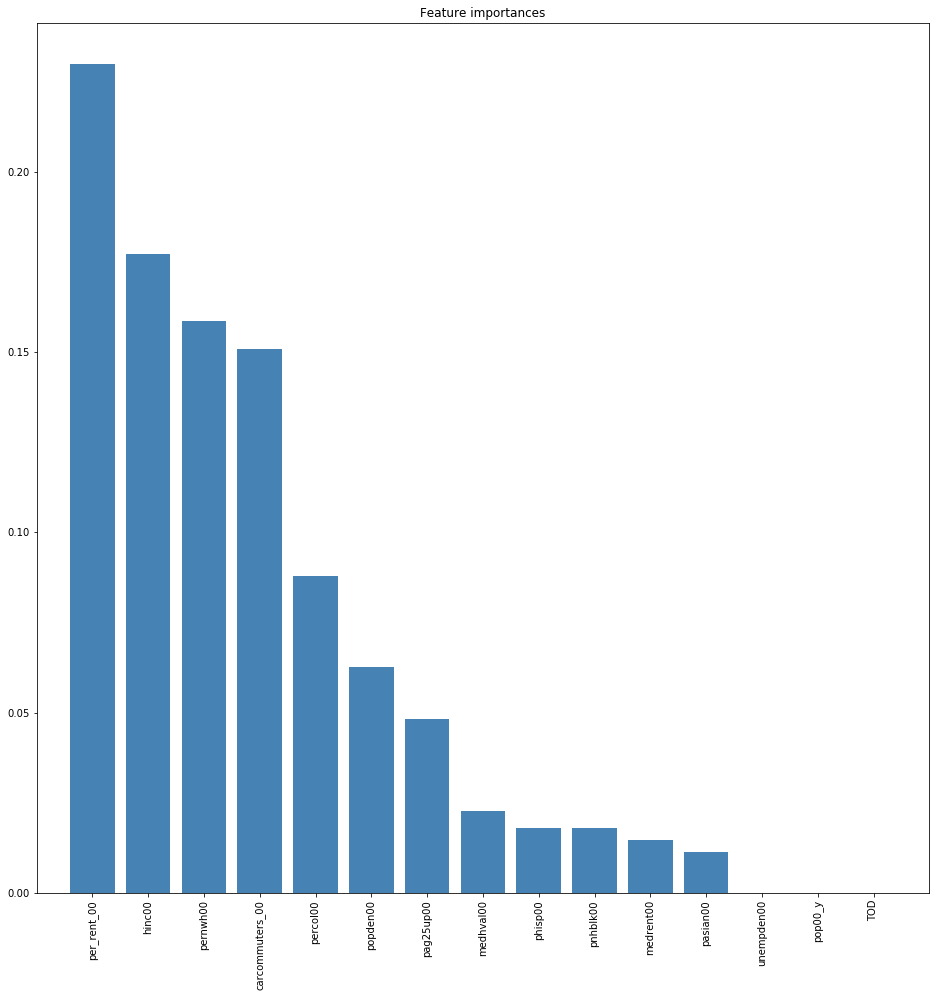

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


supergent_target trainscore:  0.984911242604 testscore:  0.982056590752 F1:  0.48 
 [[4687    8]
 [  69   65]]


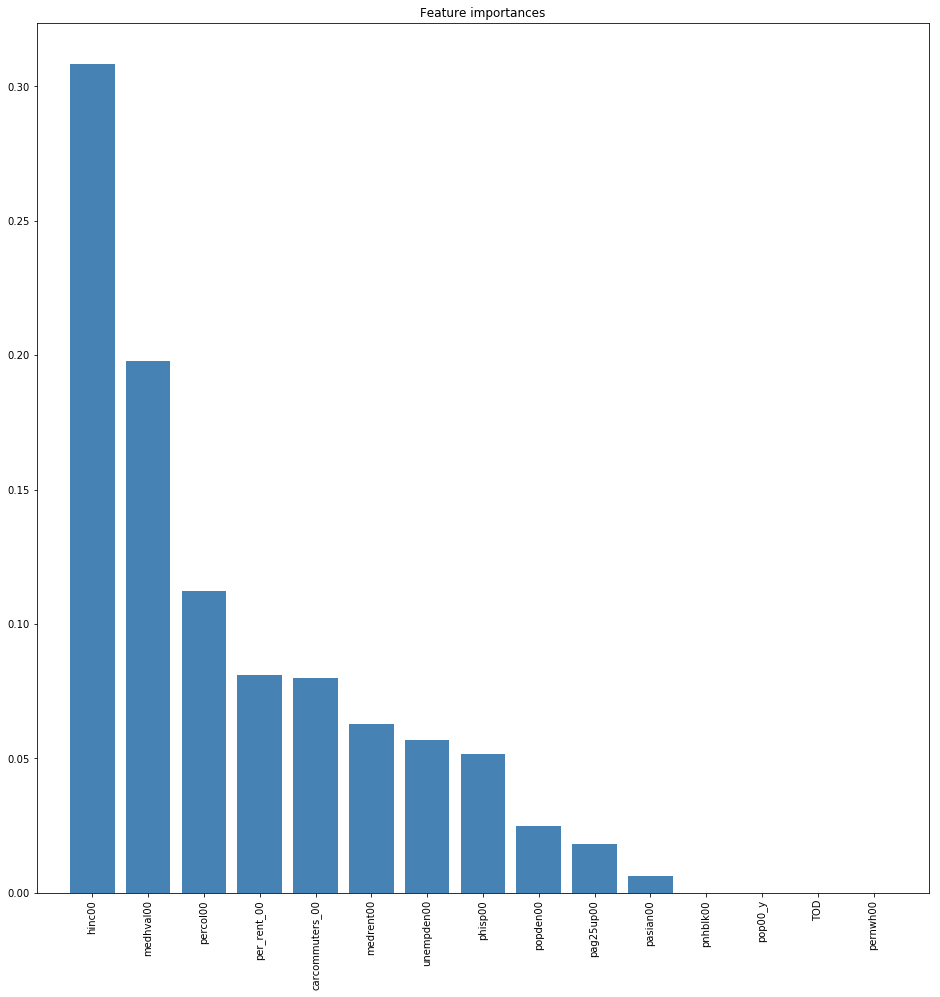

In [35]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target', ]
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_percol00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
seed = 5
print('[TN, FP][FN, TP]')
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    rf2=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf2 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf2.fit(modeldata_train, modeltarget_train)
    trainscore = rf2.score(modeldata_train, modeltarget_train)
    testscore = rf2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, rf2.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, rf2.predict(modeldata2)) )
    featureImportancePlot(rf2, modeldata2.columns)
    resdict.append({'featureset': 'censusonly', 'binaryvariable': targetnames[a], 'modeltype': 'RF', 'fscore': f1score})
    a += 1

In [36]:
resultsdf = resultsdf.append(resdict)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [37]:
resultsdf

,binaryvariable,f1score,featureset,fscore,modeltype
0,NaN,NaN,NaN,NaN,NaN
0,binary,NaN,censusonly,0.000000,DT
1,people_target,NaN,censusonly,0.012422,DT
2,people2_target,NaN,censusonly,0.285714,DT
3,place1_target,NaN,censusonly,0.288288,DT
4,place2_target,NaN,censusonly,0.000000,DT
5,gent16_target,NaN,censusonly,0.388350,DT
6,supergent_target,NaN,censusonly,0.634146,DT
7,binary,NaN,censusonly,0.024390,logit
8,people_target,NaN,censusonly,0.180851,logit


In [38]:
#censussubset[['medrent00', 'medhval00', 'percol00', 'per_rent_00', 'pernwh00', 'hinc00',   'TOD',   'carcommuters_00']].to_csv('Data/originalcensusfeatures.csv')

### Modelling the Twitter data alone

In [39]:
all = fulldataset.merge(twitter, left_on="geojoin", right_on="tract")

In [40]:
binary_subset=all[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets'
           ]]

In [41]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']

In [42]:
targets1 = [all[['Type_binary']], all[['pct_ch_hinc00_16_binary']], all[['pct_ch_percol00_16_binary']], all[['pct_ch_medhval00_16_binary']], all[['pct_ch_medrent00_16_binary']], all[['gent00_16_y']], all[['Supergent16']]]

In [43]:
a=0 
print('[TN, FP][FN, TP]')
resdicttwitter = []
for n in targets1: 
    modeldata1= binary_subset
    modeltarget1 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata1, modeltarget1, test_size = 0.3, random_state = 1)
    clf =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf.score(modeldata_train, modeltarget_train)
    testscore = clf.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, clf.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n' , metrics.confusion_matrix(modeltarget1, clf.predict(modeldata1)))
   # featureImportancePlot(clf, modeldata1.columns)
    resdicttwitter.append({'featureset': 'twitteronly', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.871853546911 testscore:  0.863393810032 F1:  0.0 
 [[2710    4]
 [ 404    4]]
people_target trainscore:  0.839816933638 testscore:  0.860192102455 F1:  0.0 
 [[2636    6]
 [ 475    5]]
people2_target trainscore:  0.886956521739 testscore:  0.897545357524 F1:  0.0 
 [[2775    7]
 [ 336    4]]
place1_target trainscore:  0.907551487414 testscore:  0.905016008538 F1:  0.0 
 [[2830    0]
 [ 291    1]]
place2_target trainscore:  0.885583524027 testscore:  0.897545357524 F1:  0.142857142857 
 [[2729   50]
 [ 296   47]]
gent16_target trainscore:  0.94004576659 testscore:  0.946638207044 F1:  0.0 
 [[2935    2]
 [ 179    6]]
supergent_target trainscore:  0.977116704805 testscore:  0.980789754536 F1:  0.0 
 [[3052    1]
 [  67    2]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
#targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets = [full[['Type_binary']], full[['pct_ch_hinc00_16_binary']], full[['pct_ch_medhval00_16_binary']], full[['pct_ch_medrent00_16_binary']], full[['gent00_16_y']], full[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
resdicttwitter = []
for n in targets1: 
    modeldata1= binary_subset
    modeltarget1 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata1, modeltarget1, test_size = 0.3, random_state = 1)
    clf =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf.score(modeldata_train, modeltarget_train)
    testscore = clf.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, clf.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n' , metrics.confusion_matrix(modeltarget1, clf.predict(modeldata1)))
   # featureImportancePlot(clf, modeldata1.columns)
    resdicttwitter.append({'featureset': 'twitteronly', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.871853546911 testscore:  0.863393810032 F1:  0.0 
 [[2710    4]
 [ 404    4]]
people_target trainscore:  0.839816933638 testscore:  0.860192102455 F1:  0.0 
 [[2636    6]
 [ 475    5]]
people2_target trainscore:  0.886956521739 testscore:  0.897545357524 F1:  0.0 
 [[2775    7]
 [ 336    4]]
place1_target trainscore:  0.907551487414 testscore:  0.905016008538 F1:  0.0 
 [[2830    0]
 [ 291    1]]
place2_target trainscore:  0.885583524027 testscore:  0.897545357524 F1:  0.142857142857 
 [[2729   50]
 [ 296   47]]
gent16_target trainscore:  0.94004576659 testscore:  0.946638207044 F1:  0.0 
 [[2935    2]
 [ 179    6]]
supergent_target trainscore:  0.977116704805 testscore:  0.980789754536 F1:  0.0 
 [[3052    1]
 [  67    2]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
resultsdf = resultsdf.append(resdicttwitter)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Building a more robust model by adding census and other features to reduce the number of FN results and improve the number of TP results

In [46]:
#list(full.columns)

In [47]:
centwitter = all[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
 ## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
 # new census features
  'pop00_y', 
  'phisp00',
  'pnhblk00', 
  'pasian00', 
 'popden00',
  'unempden00', 
  'pag25up00',
  'Type_binary',
 'pct_ch_hinc00_16_binary',
  'pct_ch_percol00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [48]:
centwitter.shape

(3122, 54)

In [49]:
#centwitter=centwitter.dropna()

In [50]:
centwitter.iloc[:, 0:-7].head()

,total_tweets,userwith5_count,total_users,Monday_oddratio,Tuesday_oddratio,Wednesday_oddratio,Thursday_oddratio,Friday_oddratio,Saturday_oddratio,Sunday_oddratio,...,hinc00,TOD,carcommuters_00,pop00_y,phisp00,pnhblk00,pasian00,popden00,unempden00,pag25up00
0,58602,1100,4767,0.144398,0.144620,0.148050,0.142862,0.142094,0.133835,0.144142,...,120523.998898,0.0,0.875731,7057.575996,0.034546,0.005805,0.030440,2.468170e+06,3.424617e+04,0.711879
1,61747,810,3917,0.152639,0.159668,0.146096,0.151473,0.130516,0.126727,0.132881,...,72720.400000,1.0,0.736007,4398.000000,0.094361,0.003411,0.091178,4.563025e+06,1.545909e+05,0.738972
2,12882,257,1214,0.138643,0.151917,0.129405,0.134063,0.136004,0.158361,0.151374,...,73386.248102,0.0,0.000000,2764.314876,0.126524,0.009439,0.069300,5.301643e+06,6.939554e+04,0.719725
3,5277,115,578,0.139473,0.124503,0.158234,0.165245,0.138336,0.137768,0.136441,...,84320.400000,0.0,0.180912,2539.000000,0.349744,0.173297,0.051595,2.665509e+08,9.973351e+06,0.727959
4,40040,522,1678,0.131319,0.129970,0.132293,0.137512,0.118906,0.162363,0.187637,...,42744.550000,0.0,0.384564,4252.000000,0.805033,0.013170,0.013170,1.318298e+08,4.805648e+06,0.648401


In [51]:
CTmodeldata=centwitter.iloc[:, 0:-7]
CTmodeltarget=centwitter.iloc[:,-7:]

[TN, FP][FN, TP]
binary trainscore:  0.874599542334 testscore:  0.872998932764 F1:  0.143884892086 
 [[2696   18]
 [ 375   33]]


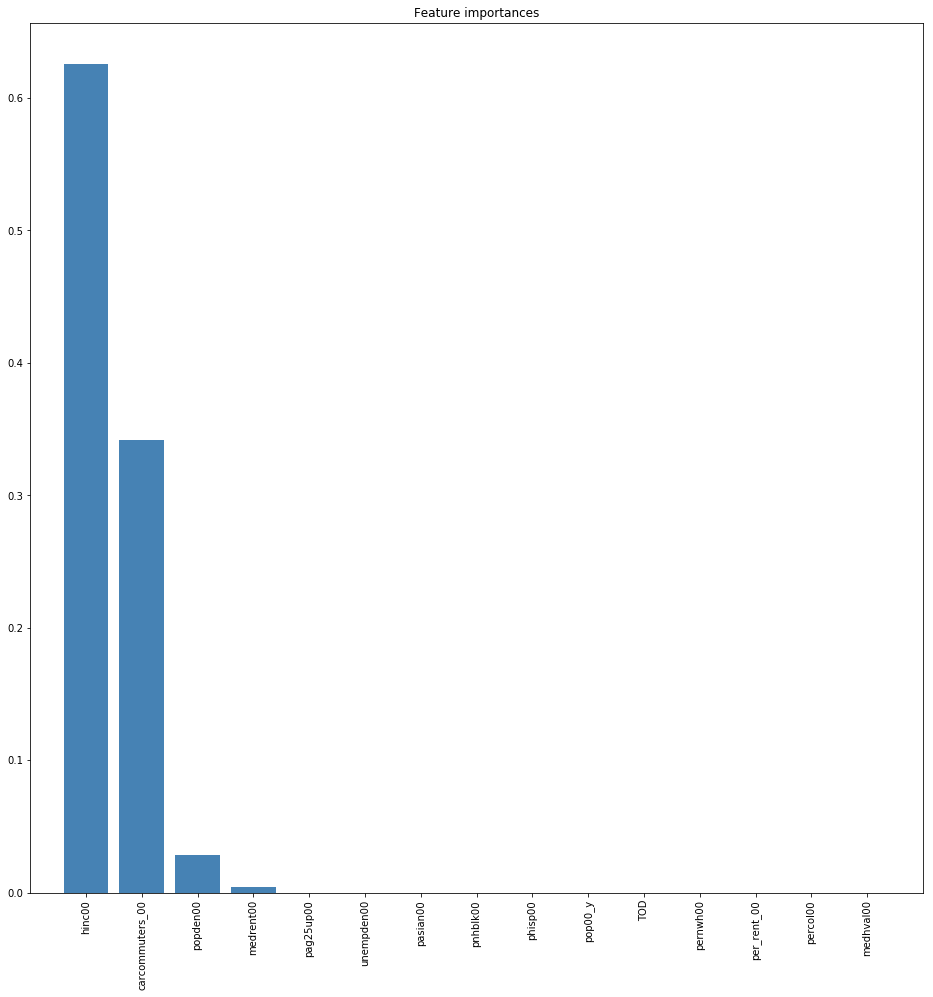

people_target trainscore:  0.858581235698 testscore:  0.84204909285 F1:  0.281553398058 
 [[2538  104]
 [ 353  127]]


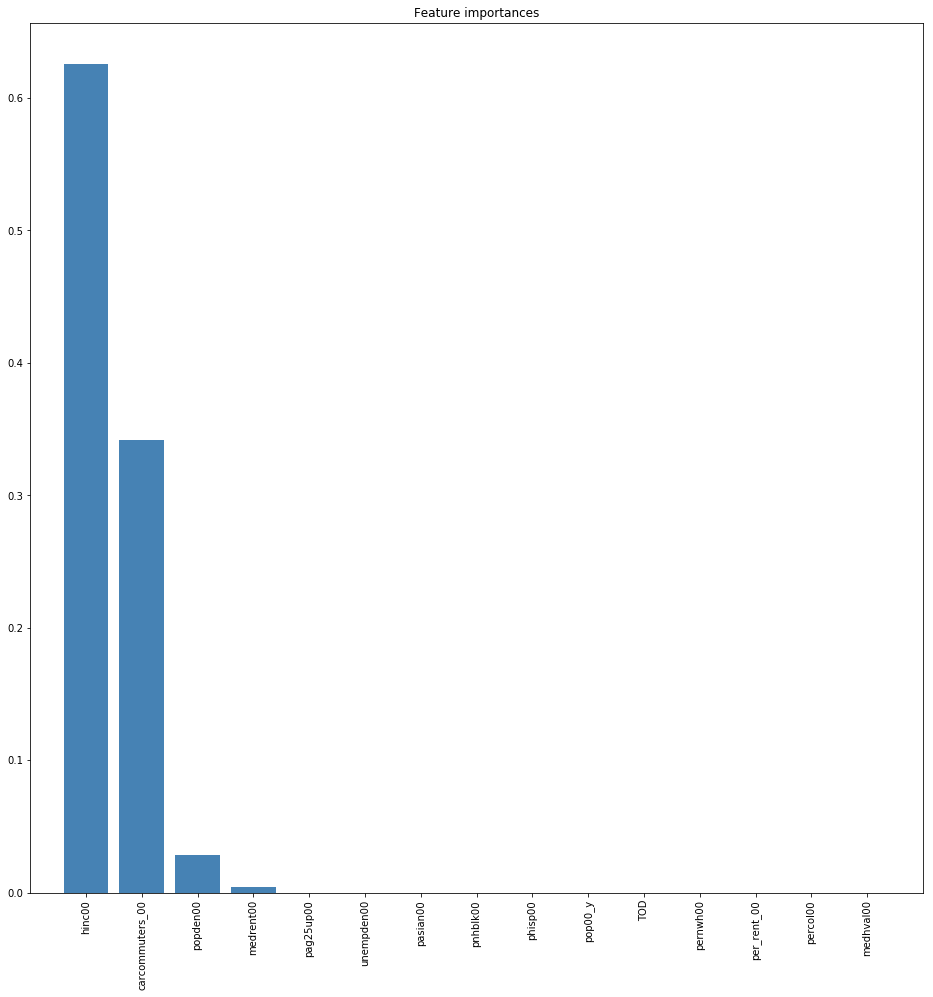

people2_target trainscore:  0.90938215103 testscore:  0.900747065101 F1:  0.300751879699 
 [[2720   62]
 [ 229  111]]


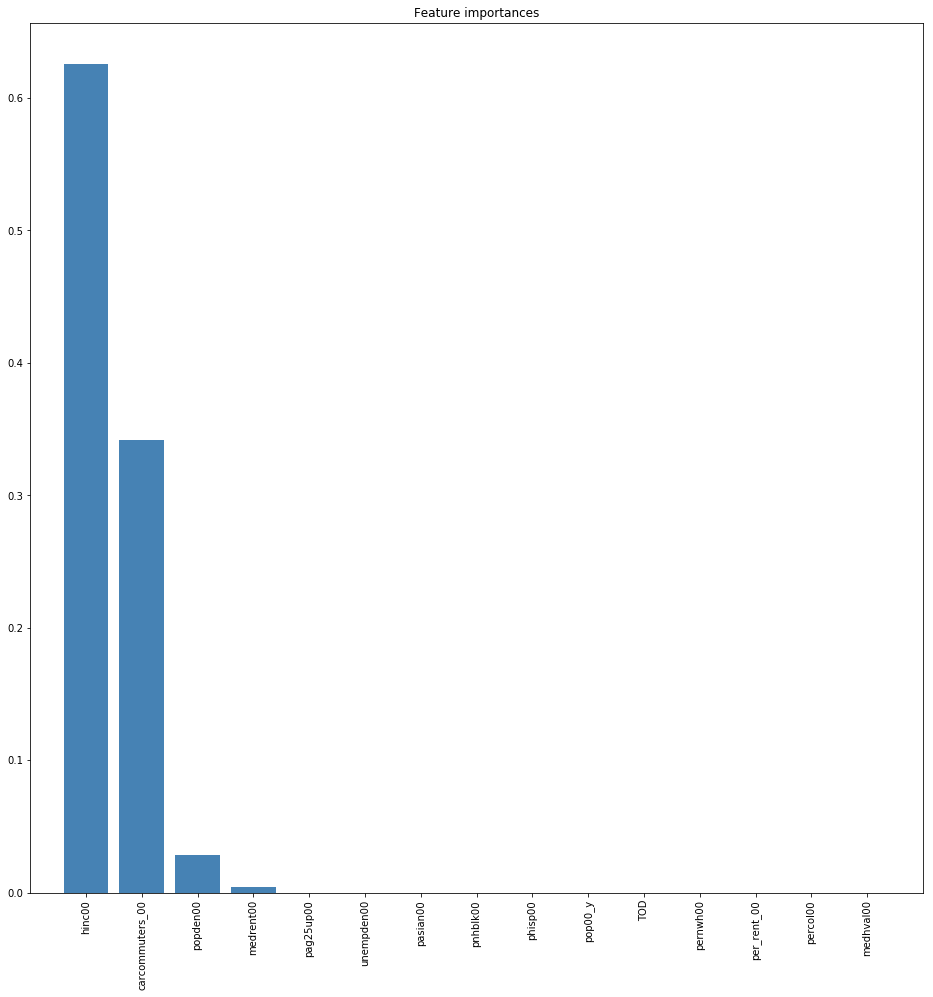

place1_target trainscore:  0.916704805492 testscore:  0.918890074707 F1:  0.415384615385 
 [[2782   48]
 [ 210   82]]


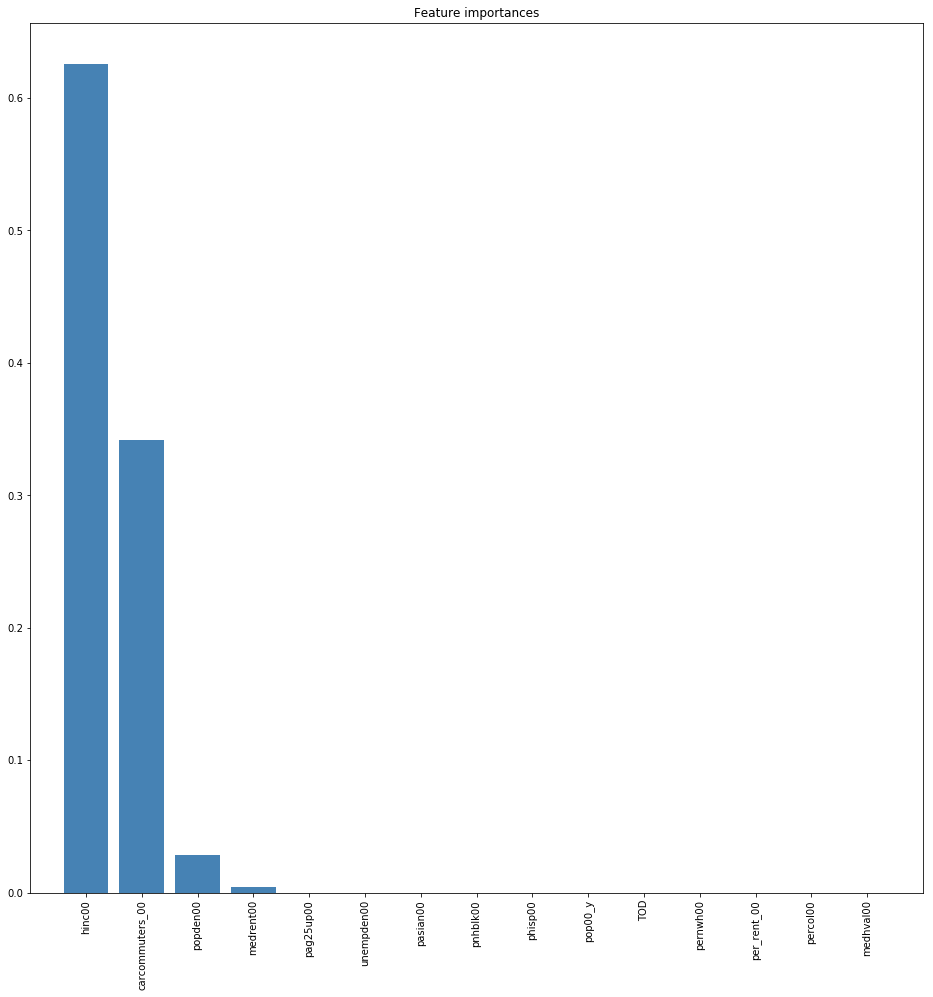

place2_target trainscore:  0.886041189931 testscore:  0.910352187834 F1:  0.0232558139535 
 [[2779    0]
 [ 333   10]]


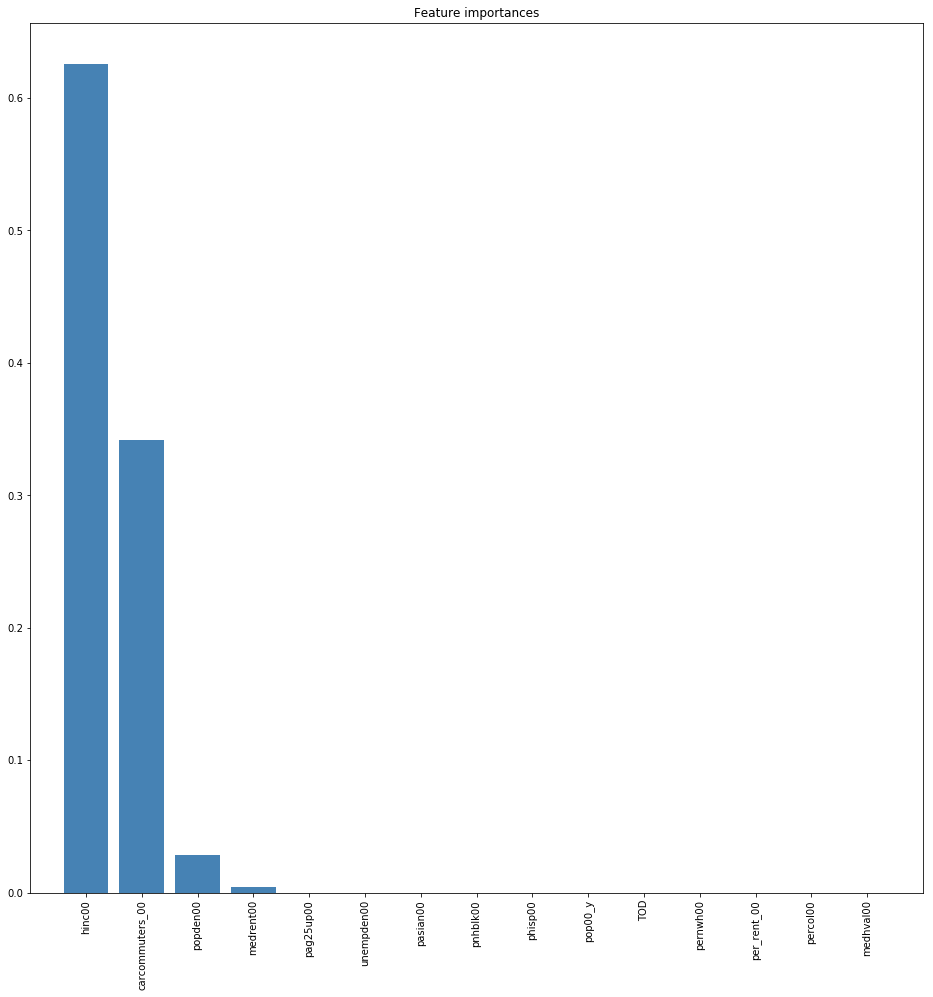

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


gent16_target trainscore:  0.937299771167 testscore:  0.948772678762 F1:  0.0 
 [[2937    0]
 [ 185    0]]


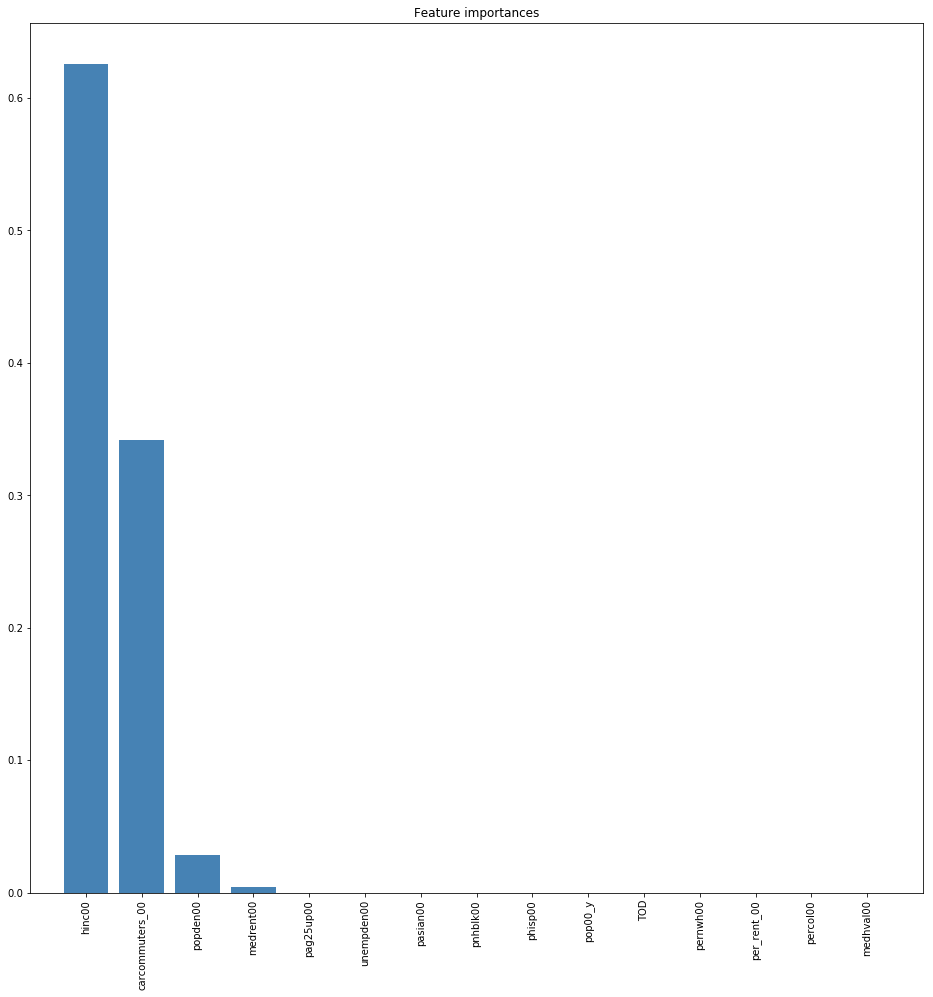

supergent_target trainscore:  0.993592677346 testscore:  0.985058697972 F1:  0.611111111111 
 [[3037   16]
 [  12   57]]


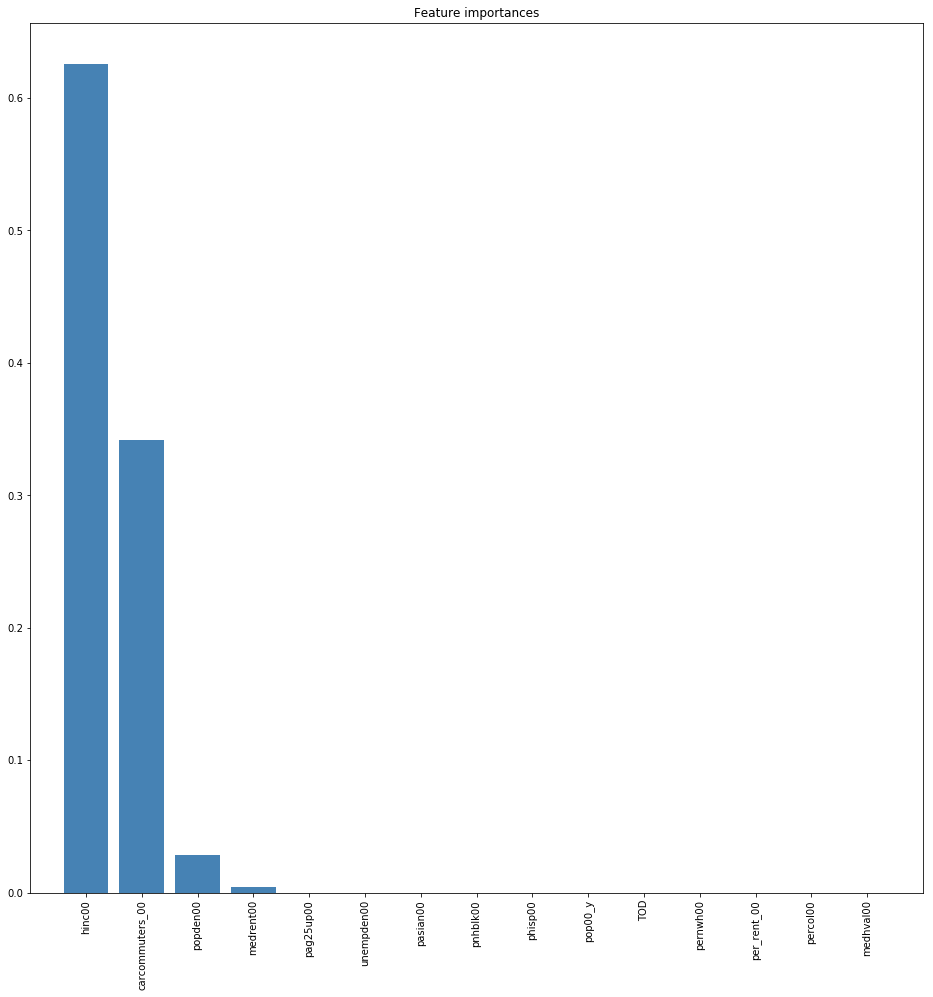

In [52]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targetsCT = [centwitter[['Type_binary']], centwitter[['pct_ch_hinc00_16_binary']], centwitter[['pct_ch_percol00_16_binary']],  centwitter[['pct_ch_medhval00_16_binary']], centwitter[['pct_ch_medrent00_16_binary']], centwitter[['gent00_16_y']], centwitter[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
resdicttwittercen = []
for n in targetsCT: 
    modeldataCT= CTmodeldata
    modeltargetCT = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldataCT, modeltargetCT, test_size = 0.3, random_state = 1)
    clfCT =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clfCT.score(modeldata_train, modeltarget_train)
    testscore = clfCT.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, clfCT.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltargetCT, clfCT.predict(modeldataCT)) )
    resdicttwittercen.append({'featureset': 'centwitter', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    featureImportancePlot(clf2, modeldata2.columns)
    a += 1

In [53]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targetsCT = [centwitter[['Type_binary']], centwitter[['pct_ch_hinc00_16_binary']], centwitter[['pct_ch_percol00_16_binary']],  centwitter[['pct_ch_medhval00_16_binary']], centwitter[['pct_ch_medrent00_16_binary']], centwitter[['gent00_16_y']], centwitter[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
for n in targetsCT: 
    modeldataCT= CTmodeldata
    modeltargetCT = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldataCT, modeltargetCT, test_size = 0.3, random_state = 1)
    logit_CT = LogisticRegression(C = 10000)
    logit_CT.fit(modeldata_train, modeltarget_train)
    trainscore = logit_CT.score(modeldata_train, modeltarget_train)
    testscore = logit_CT.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, logit_CT.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltargetCT, clfCT.predict(modeldataCT)) )
    resdicttwittercen.append({'featureset': 'centwitter', 'binaryvariable': targetnames[a], 'modeltype': 'Logit', 'fscore': f1score})
    # featureImportancePlot(logit_2, modeldata2.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870480549199 testscore:  0.867662753469 F1:  0.0 
 [[2642   72]
 [ 407    1]]
people_target trainscore:  0.842105263158 testscore:  0.86552828175 F1:  0.0869565217391 
 [[2572   70]
 [ 477    3]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

people2_target trainscore:  0.891990846682 testscore:  0.894343649947 F1:  0.0747663551402 
 [[2709   73]
 [ 340    0]]
place1_target trainscore:  0.906178489703 testscore:  0.91462113127 F1:  0.285714285714 
 [[2757   73]
 [ 292    0]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

place2_target trainscore:  0.881464530892 testscore:  0.909284951974 F1:  0.0229885057471 
 [[2719   60]
 [ 330   13]]
gent16_target trainscore:  0.937299771167 testscore:  0.948772678762 F1:  0.0 
 [[2894   43]
 [ 155   30]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

supergent_target trainscore:  0.973913043478 testscore:  0.978655282818 F1:  0.230769230769 
 [[3037   16]
 [  12   57]]


In [54]:
targetnames = ['binary', 'people_target', 'people2_target','place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets2 =  [centwitter[['Type_binary']], centwitter[['pct_ch_hinc00_16_binary']], centwitter[['pct_ch_percol00_16_binary']], centwitter[['pct_ch_medhval00_16_binary']], centwitter[['pct_ch_medrent00_16_binary']], centwitter[['gent00_16_y']], centwitter[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
seed = 5
for n in targetsCT: 
    modeldataCT= CTmodeldata
    modeltargetCT = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldataCT, modeltargetCT, test_size = 0.3, random_state = 1)
    param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
    rfCT=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rfCT = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rfCT.fit(modeldata_train, modeltarget_train)
    trainscore = rfCT.score(modeldata_train, modeltarget_train)
    testscore = rfCT.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, rfCT.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltargetCT, clfCT.predict(modeldataCT)) )
    # featureImportancePlot(rf2, modeldata2.columns)
    resdicttwittercen.append({'featureset': 'centwitter', 'binaryvariable': targetnames[a], 'modeltype': 'RF', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870022883295 testscore:  0.866595517609 F1:  0.0 
 [[2642   72]
 [ 407    1]]
people_target trainscore:  0.84118993135 testscore:  0.86552828175 F1:  0.015625 
 [[2572   70]
 [ 477    3]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

people2_target trainscore:  0.896109839817 testscore:  0.905016008538 F1:  0.118811881188 
 [[2709   73]
 [ 340    0]]
place1_target trainscore:  0.907551487414 testscore:  0.905016008538 F1:  0.0 
 [[2757   73]
 [ 292    0]]
place2_target trainscore:  0.8823798627 testscore:  0.909284951974 F1:  0.0 
 [[2719   60]
 [ 330   13]]
gent16_target trainscore:  0.938215102975 testscore:  0.948772678762 F1:  0.0 
 [[2894   43]
 [ 155   30]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 

supergent_target trainscore:  0.990846681922 testscore:  0.987193169691 F1:  0.5 
 [[3037   16]
 [  12   57]]


In [55]:
resultsdf = resultsdf.append(resdicttwittercen)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Incorporating Distance features

Distance features to high visitor tracts, high tweet tract, and high income neighborhoods were added based on the findings in our literature review and data exploration

In [56]:
dist=pd.read_csv('Data/twitter_distance.csv', index_col=0)

In [57]:
dist.columns

Index(['geoid', 'distToHighVisitorTract', 'distToHighTweetTract', 'distToMHI'], dtype='object')

In [58]:
withdist=all.merge(dist, right_on='geoid', left_on='geojoin')

In [59]:
distdata=withdist[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
 # new census features
  'pop00_y', 
  'phisp00',
  'pnhblk00', 
  'pasian00', 
 'popden00',
  'unempden00', 
  'pag25up00',
## dist features
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
## dependent variables
  'Type_binary',
  'pct_ch_hinc00_16_binary',
  'pct_ch_percol00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [60]:
distdata = distdata.dropna()

[TN, FP][FN, TP]
binary trainscore:  0.876668200644 testscore:  0.842274678112 F1:  0.187845303867 
 [[2616   81]
 [ 334   74]]


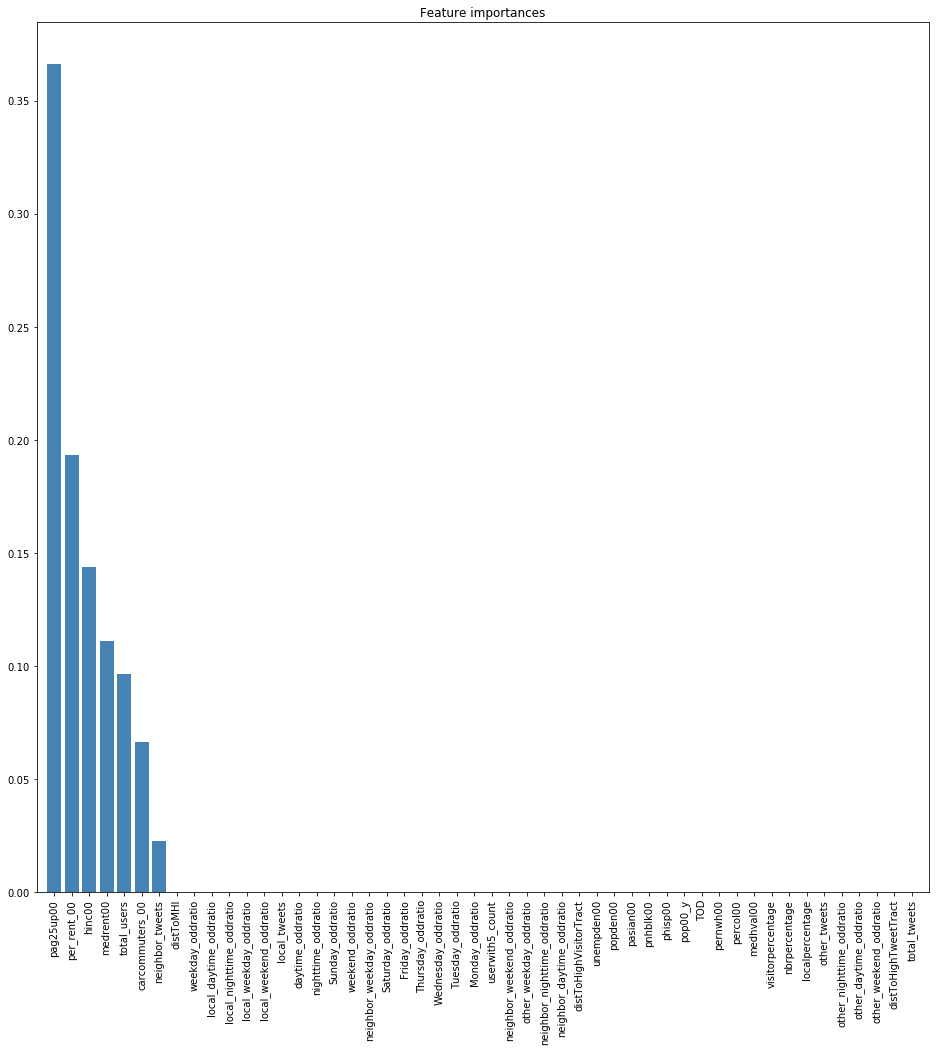

people_target trainscore:  0.880349746894 testscore:  0.868025751073 F1:  0.196078431373 
 [[2618    8]
 [ 375  104]]


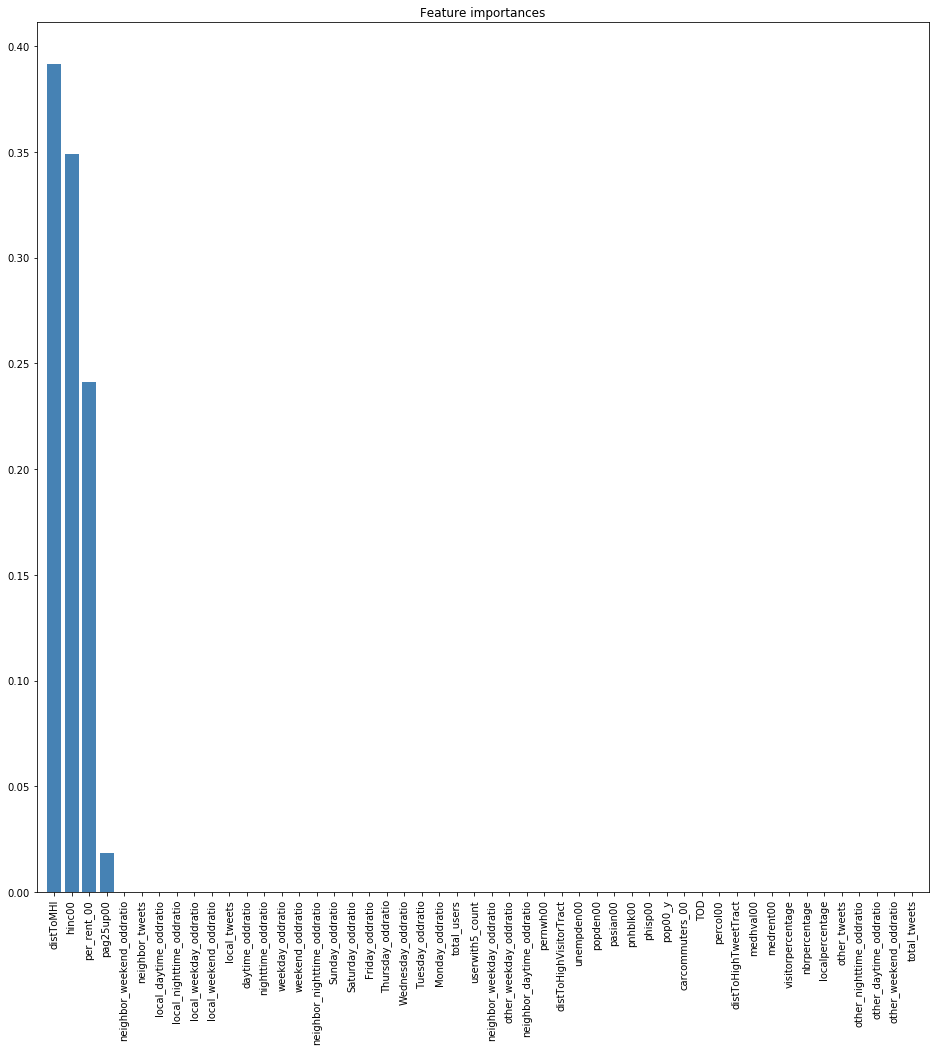

people2_target trainscore:  0.912103083295 testscore:  0.891630901288 F1:  0.312925170068 
 [[2728   37]
 [ 255   85]]


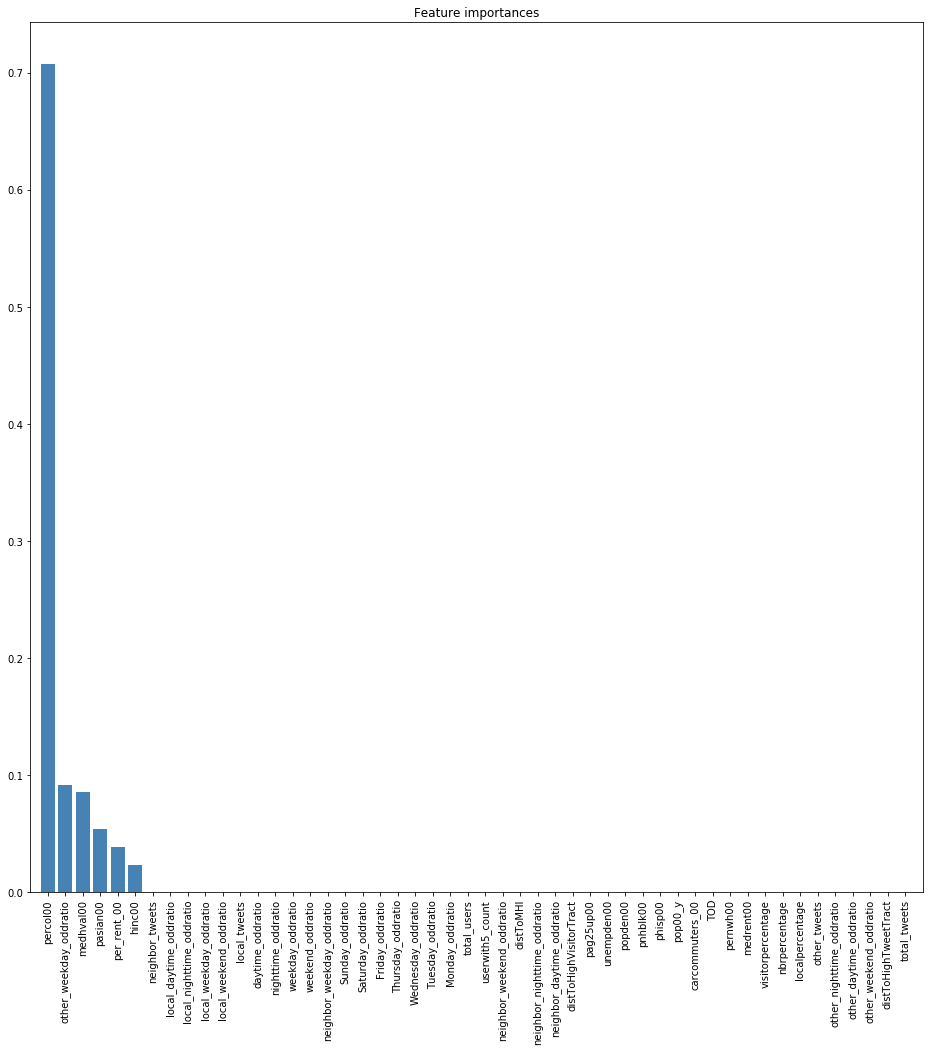

place1_target trainscore:  0.918545789231 testscore:  0.915236051502 F1:  0.217821782178 
 [[2806    7]
 [ 249   43]]


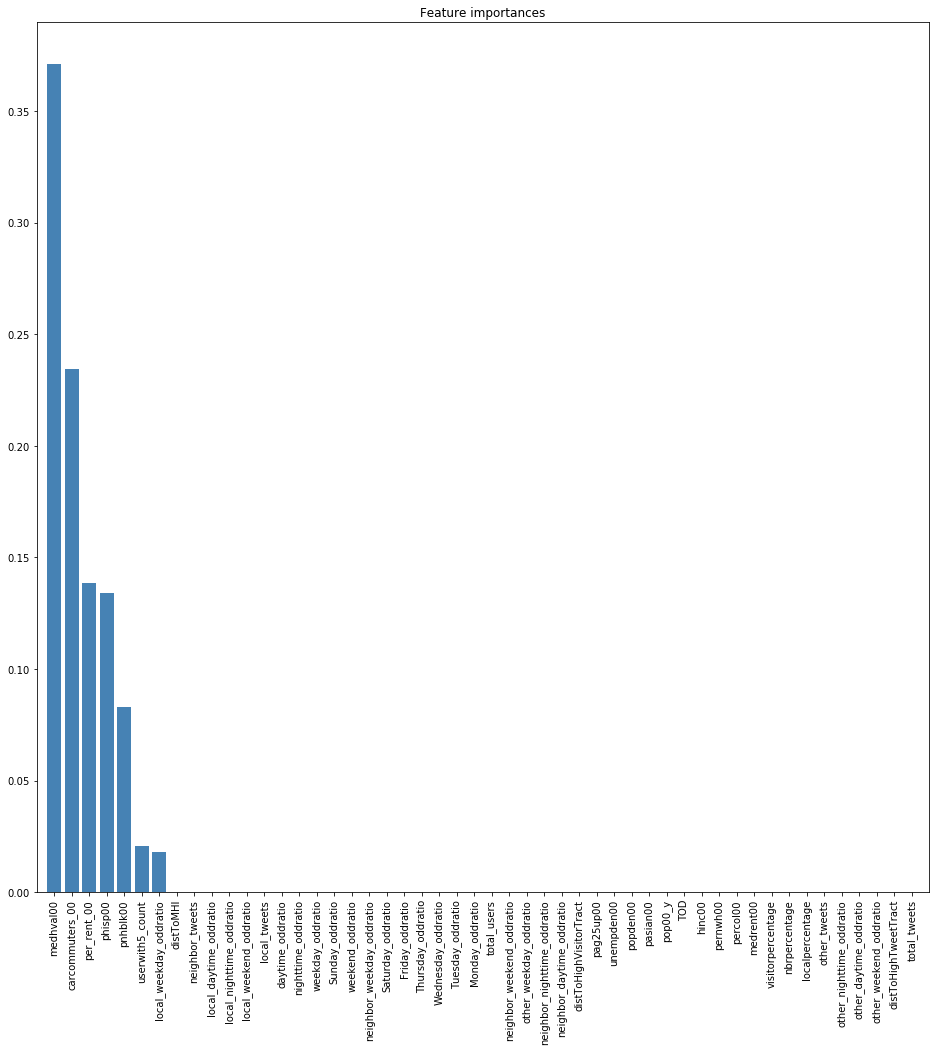

place2_target trainscore:  0.892314772204 testscore:  0.896995708155 F1:  0.04 
 [[2763    0]
 [ 330   12]]


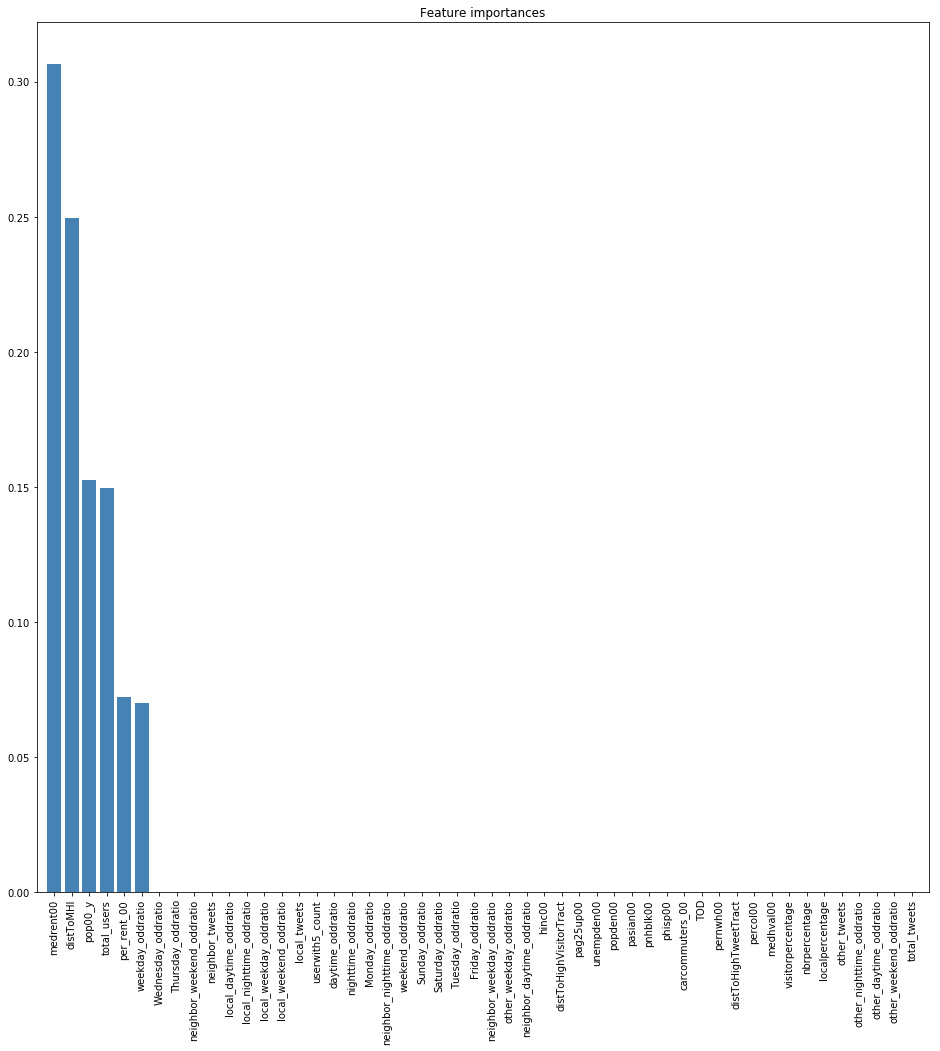

gent16_target trainscore:  0.942015646572 testscore:  0.919527896996 F1:  0.380165289256 
 [[2813  108]
 [  93   91]]


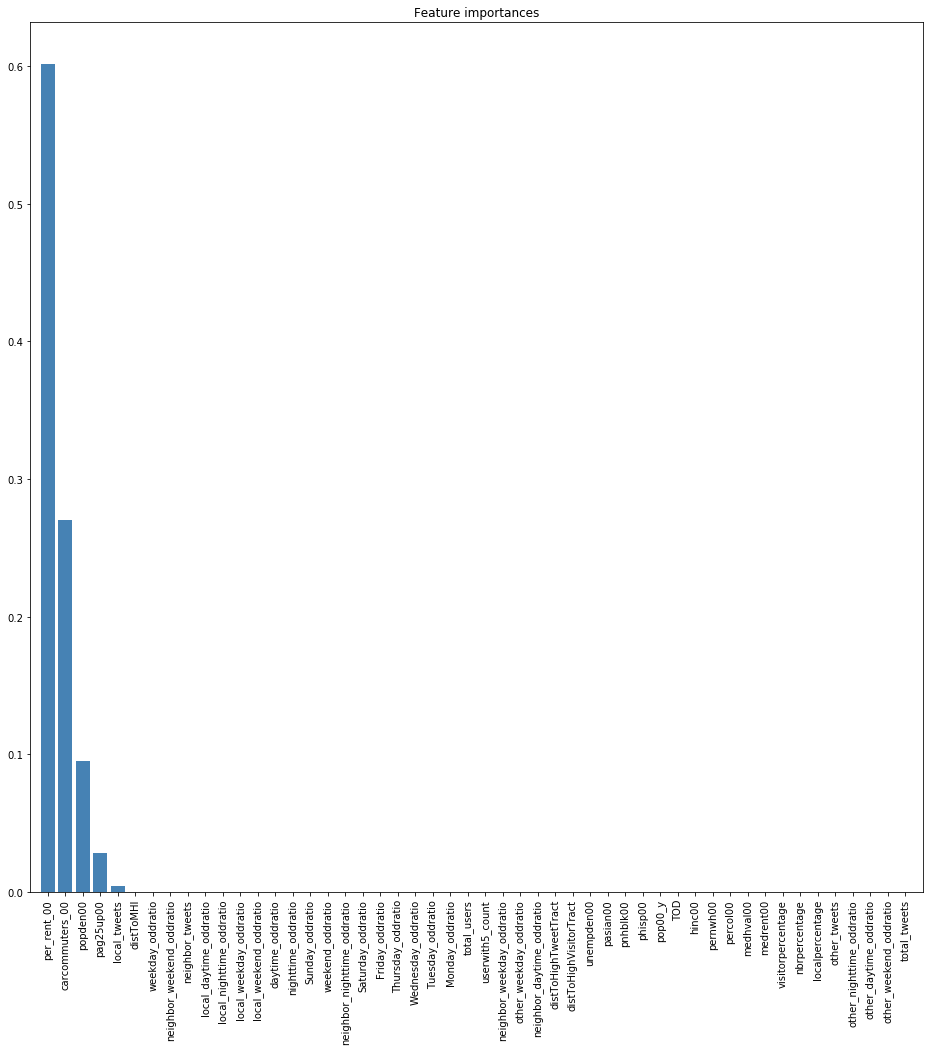

supergent_target trainscore:  0.992636907501 testscore:  0.982832618026 F1:  0.714285714286 
 [[3016   23]
 [   9   57]]


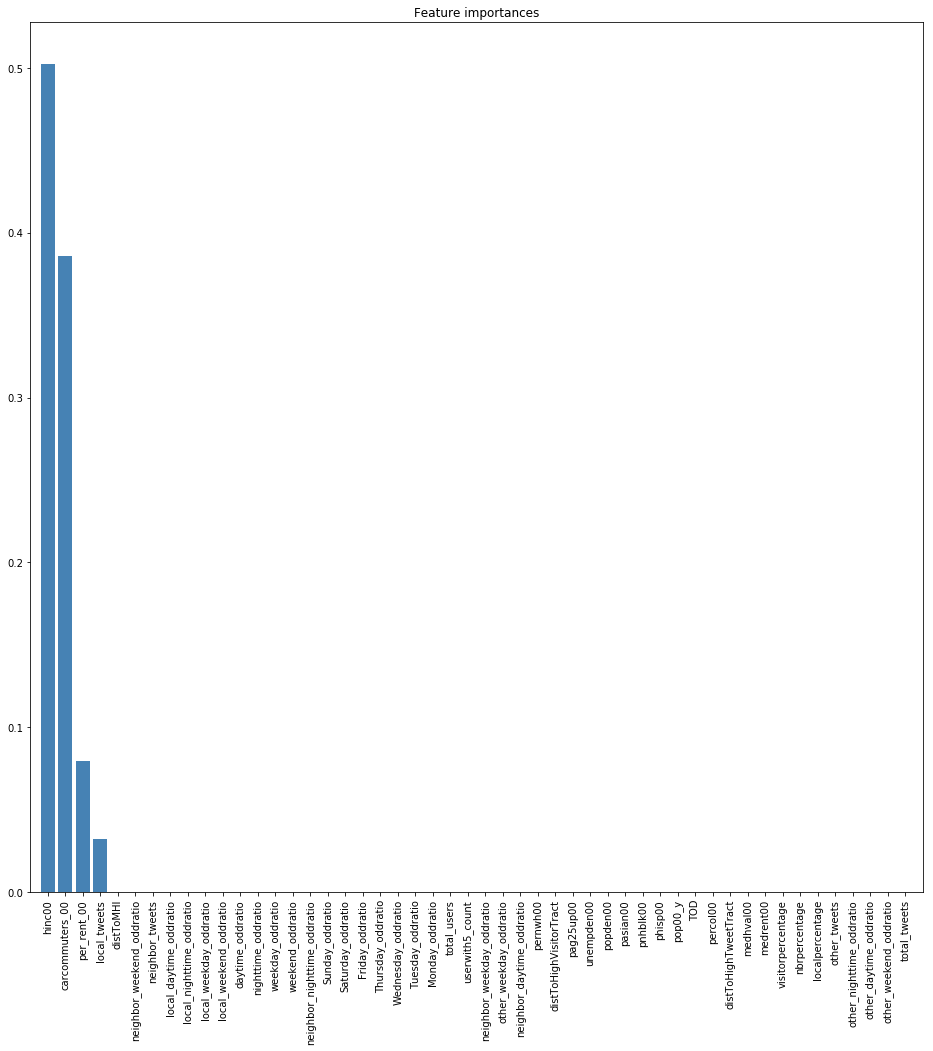

In [61]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_percol00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-7]
a=0 
print('[TN, FP][FN, TP]')
resdist = []
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    clf3 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf3.score(modeldata_train, modeltarget_train)
    testscore = clf3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, clf3.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, clf3.predict(modeldata3)) )
    featureImportancePlot(clf3, modeldata3.columns)
    resdist.append({'featureset': 'CT + distances', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

In [62]:
#targetnames = ['binary', 'people_target', 'people2_target','place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_percol00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-7]
a=0 
print('[TN, FP][FN, TP]')
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    logit_3 = LogisticRegression(C = 10000)
    logit_3.fit(modeldata_train, modeltarget_train)
    trainscore = logit_3.score(modeldata_train, modeltarget_train)
    testscore = logit_3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, logit_3.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, logit_3.predict(modeldata3)) )
    #featureImportancePlot(logit_3, modeldata3.columns)
    resdist.append({'featureset': 'CT + distances', 'binaryvariable': targetnames[a], 'modeltype': 'Logit', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.869765301427 testscore:  0.857296137339 F1:  0.0 
 [[2682   15]
 [ 401    7]]
people_target trainscore:  0.843074091118 testscore:  0.864806866953 F1:  0.181818181818 
 [[2594   32]
 [ 435   44]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

people2_target trainscore:  0.89047399908 testscore:  0.896995708155 F1:  0.172413793103 
 [[2746   19]
 [ 315   25]]
place1_target trainscore:  0.908421537046 testscore:  0.904506437768 F1:  0.168224299065 
 [[2775   38]
 [ 250   42]]
place2_target trainscore:  0.888633225955 testscore:  0.891630901288 F1:  0.0 
 [[2755    8]
 [ 335    7]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

gent16_target trainscore:  0.941095260009 testscore:  0.938841201717 F1:  0.0 
 [[2920    1]
 [ 184    0]]
supergent_target trainscore:  0.978831109066 testscore:  0.969957081545 F1:  0.125 
 [[3023   16]
 [  58    8]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
#targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_percol00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-7]
a=0 
print('[TN, FP][FN, TP]')
seed = 5
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    rf3=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf3 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf3.fit(modeldata_train, modeltarget_train)
    trainscore = rf3.score(modeldata_train, modeltarget_train)
    testscore = rf3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, rf3.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, rf3.predict(modeldata3)) )
   # featureImportancePlot(rf3, modeldata3.columns)
    resdist.append({'featureset': 'CT + distances', 'binaryvariable': targetnames[a], 'modeltype': 'RF', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.870685687989 testscore:  0.864806866953 F1:  0.015625 
 [[2696    1]
 [ 406    2]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

people_target trainscore:  0.850897376898 testscore:  0.856223175966 F1:  0.0289855072464 
 [[2622    4]
 [ 454   25]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


people2_target trainscore:  0.898757478141 testscore:  0.894849785408 F1:  0.0925925925926 
 [[2761    4]
 [ 314   26]]
place1_target trainscore:  0.913023469857 testscore:  0.915236051502 F1:  0.168421052632 
 [[2807    6]
 [ 262   30]]
place2_target trainscore:  0.890013805798 testscore:  0.896995708155 F1:  0.04 
 [[2763    0]
 [ 335    7]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

gent16_target trainscore:  0.942015646572 testscore:  0.93991416309 F1:  0.0 
 [[2921    0]
 [ 182    2]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


supergent_target trainscore:  0.99217671422 testscore:  0.978540772532 F1:  0.375 
 [[3033    6]
 [  31   35]]


In [64]:
resultsdf = resultsdf.append(resdist)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [65]:
#resultsdf.to_csv('Data/resultsdf.csv')

# Adding Twitter Timing and Visitor Demographics

In [66]:
twitterdemo = pd.read_csv('Data/twitter_visitor_edu_inc.csv', index_col=0)

In [67]:
twitterdemo.head(10)

,tract,inc,percent_inc,edu,percent_edu
0,9.001010e+09,high,32.337165,high,29.961686
1,9.001010e+09,high,32.337165,low,6.245211
2,9.001010e+09,high,32.337165,med,11.264368
3,9.001010e+09,low,6.015326,high,29.961686
4,9.001010e+09,low,6.015326,low,6.245211
5,9.001010e+09,low,6.015326,med,11.264368
6,9.001010e+09,med,9.118774,high,29.961686
7,9.001010e+09,med,9.118774,low,6.245211
8,9.001010e+09,med,9.118774,med,11.264368
9,9.001010e+09,high,12.241888,high,12.157606


In [68]:
twitterinc = pd.DataFrame(twitterdemo[twitterdemo['inc'] == 'high'].percent_inc.groupby(twitterdemo['tract']).mean())

In [69]:
twitterinc['lowinc'] = twitterdemo[twitterdemo['inc'] == 'low'].percent_inc.groupby(twitterdemo['tract']).mean()

In [70]:
twitterinc['medinc'] = twitterdemo[twitterdemo['inc'] == 'med'].percent_inc.groupby(twitterdemo['tract']).mean()

In [71]:
twitterinc.rename(columns={'percent_inc':'highinc'}, inplace=True)

In [72]:
twitterinc.head()

,highinc,lowinc,medinc
tract,,,
9.001010e+09,32.337165,6.015326,9.118774
9.001010e+09,12.241888,3.329119,4.045512
9.001010e+09,17.778530,1.693193,7.619370
9.001010e+09,14.179693,2.817549,4.459477
9.001010e+09,6.793292,2.036277,5.835044


In [73]:
twitteredu =  pd.DataFrame(twitterdemo[twitterdemo['edu'] == 'high'].percent_edu.groupby(twitterdemo['tract']).mean())

In [74]:
twitteredu['lowedu'] = twitterdemo[twitterdemo['edu'] == 'low'].percent_edu.groupby(twitterdemo['tract']).mean()
twitteredu['mededu'] = twitterdemo[twitterdemo['edu'] == 'med'].percent_edu.groupby(twitterdemo['tract']).mean()
twitteredu.rename(columns={'percent_edu':'highedu'}, inplace=True)

In [75]:
twitteredu.head()

,highedu,lowedu,mededu
tract,,,
9.001010e+09,29.961686,6.245211,11.264368
9.001010e+09,12.157606,3.223767,4.235145
9.001010e+09,15.848290,1.286827,9.955977
9.001010e+09,13.168265,2.916065,5.372389
9.001010e+09,5.706708,3.490760,5.467146


In [76]:
twittertiming = pd.read_csv('Data/twitter_tract_count_2012_2015.csv', index_col=0)

In [77]:
twittertiming.head()

,year,tract,u_id
0,2012.0,9.001010e+09,668
1,2012.0,9.001010e+09,2437
2,2012.0,9.001010e+09,476
3,2012.0,9.001010e+09,494
4,2012.0,9.001010e+09,1355


In [78]:
twittertiming = twittertiming.set_index('tract')

In [79]:
twittertim = pd.DataFrame(twittertiming[twittertiming['year'] == 2012].u_id)

In [80]:
twittertim.rename(columns={'u_id':'2012count'}, inplace=True)

In [81]:
twittertim['2013count'] = twittertiming[twittertiming['year'] == 2013].u_id

In [82]:
twittertim['2014count'] = twittertiming[twittertiming['year'] == 2014].u_id

In [83]:
twitterdetails = twitterinc.merge(twitteredu, right_index=True, left_index=True)

In [84]:
twitterdetails = twitterdetails.merge(twittertim, right_index=True, left_index=True)

In [85]:
twitterdetails.columns

Index(['highinc', 'lowinc', 'medinc', 'highedu', 'lowedu', 'mededu',
       '2012count', '2013count', '2014count'],
      dtype='object')

In [86]:
nulls=twitterdetails.columns[twitterdetails.isnull().any()]

In [87]:
twitterdetails[nulls].isnull().sum()

lowinc    2
lowedu    2
dtype: int64

In [88]:
twitterdetails.shape

(3482, 9)

In [89]:
twitterdetails = twitterdetails.dropna()

In [90]:
withtwitterdetails = withdist.merge(twitterdetails, right_index=True, left_on='geojoin')

In [91]:
#alltwitter.to_csv('Data/alltwitterandcensus.csv')

In [92]:
#withtwitterdetails[withtwitterdetails['geojoin']==34003002200].to_csv('Data/test_value.csv')

In [96]:
alltwitter = withtwitterdetails[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent00',
 'medhval00',
 'percol00',
 'per_rent_00',
 'pernwh00',
 'hinc00', 
  'TOD', 
  'carcommuters_00',
 # new census features
  'pop00_y', 
  'phisp00',
  'pnhblk00', 
  'pasian00', 
 'popden00',
  'unempden00', 
  'pag25up00',
## dist features
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
## new twitter features
  'highinc', 
  'lowinc', 
  'medinc', 
  'highedu', 
  'lowedu', 
  'mededu',
   '2012count', 
    '2013count', 
    '2014count',
## dependent variables
  'Type_binary',
  'pct_ch_hinc00_16_binary',
 'pct_ch_percol00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [97]:
#alltwitter = manrique

In [98]:
#alltwitter.describe()

In [99]:
#manrique.describe()

alltwitter = manrique[['pop00', 'phisp00', 'pnhblk00', 'pasian00', 'popden00',
       'unempden00', 'pag25up00', 'TOD', 'medrent00', 'medhval00', 'percol00',
       'per_rent_00', 'pernwh00', 'hinc00', 'carcommuters_00', 'total_tweets',
       'userwith5_count', 'total_users', 'Monday_oddratio', 'Tuesday_oddratio',
       'Wednesday_oddratio', 'Thursday_oddratio', 'Friday_oddratio',
       'Saturday_oddratio', 'Sunday_oddratio', 'weekend_oddratio',
       'weekday_oddratio', 'nighttime_oddratio', 'daytime_oddratio',
       'local_tweets', 'local_weekend_oddratio', 'local_weekday_oddratio',
       'local_nighttime_oddratio', 'local_daytime_oddratio', 'neighbor_tweets',
       'neighbor_weekend_oddratio', 'neighbor_weekday_oddratio',
       'neighbor_nighttime_oddratio', 'neighbor_daytime_oddratio',
       'other_weekday_oddratio', 'other_weekend_oddratio',
       'other_daytime_oddratio', 'other_nighttime_oddratio', 'other_tweets',
       'localpercentage', 'nbrpercentage', 'visitorpercentage',
       'distToHighVisitorTract', 'distToHighTweetTract', 'distToMHI',
       'highinc', 'lowinc', 'medinc', 'highedu', 'lowedu', 'mededu',
       '2012count', '2013count', '2014count']]

In [100]:
#manrique['Supergent16']

In [101]:
modeldata6= alltwitter.iloc[:, 0:-7]
modeltarget6 = alltwitter[['Supergent16']]
modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata6, modeltarget6, test_size = 0.3, random_state = 1)
clf6 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
f1score = metrics.f1_score(modeltarget_test, clf6.predict(modeldata_test))

In [102]:
modeldata6.shape

(3103, 59)

In [103]:
f1score

0.70270270270270274

[TN, FP][FN, TP]
binary trainscore:  0.878913443831 testscore:  0.848549946294 F1:  0.0 
 [[2696    0]
 [ 404    3]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


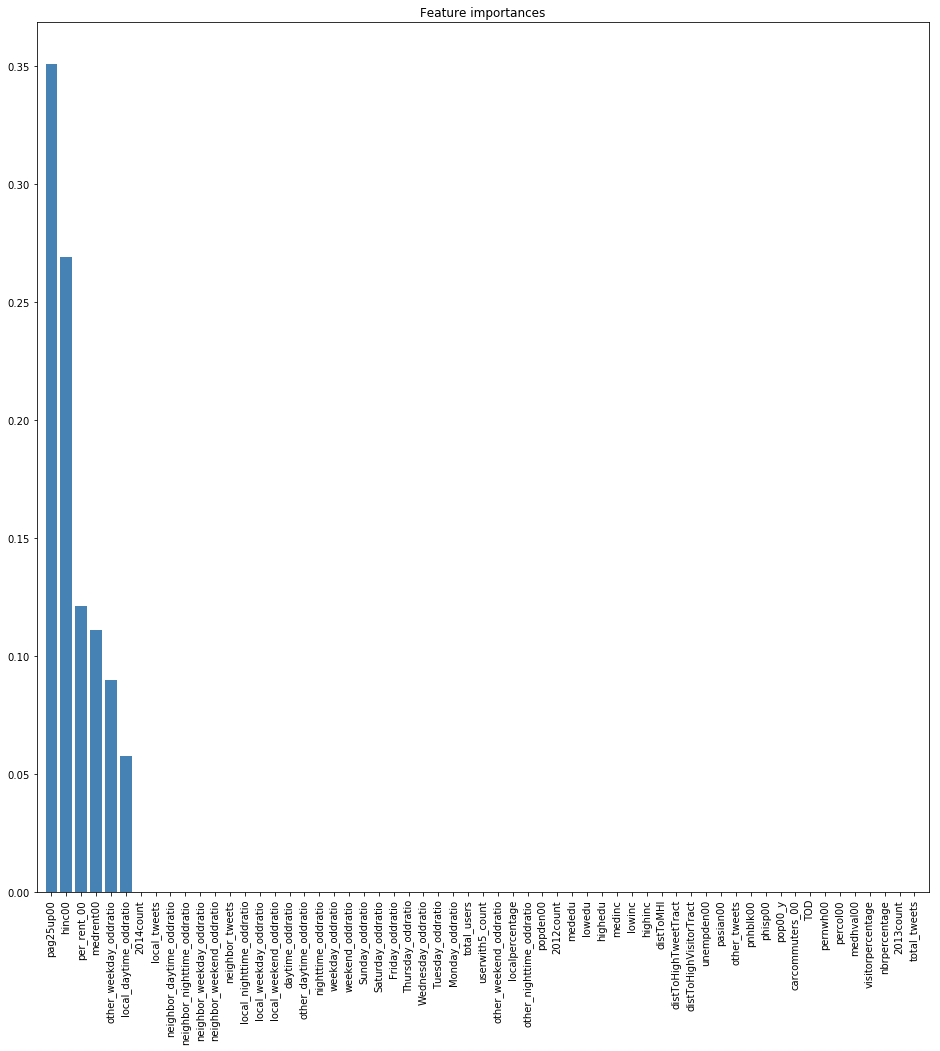

people_target trainscore:  0.871546961326 testscore:  0.886143931257 F1:  0.459183673469 
 [[2519  105]
 [ 280  199]]


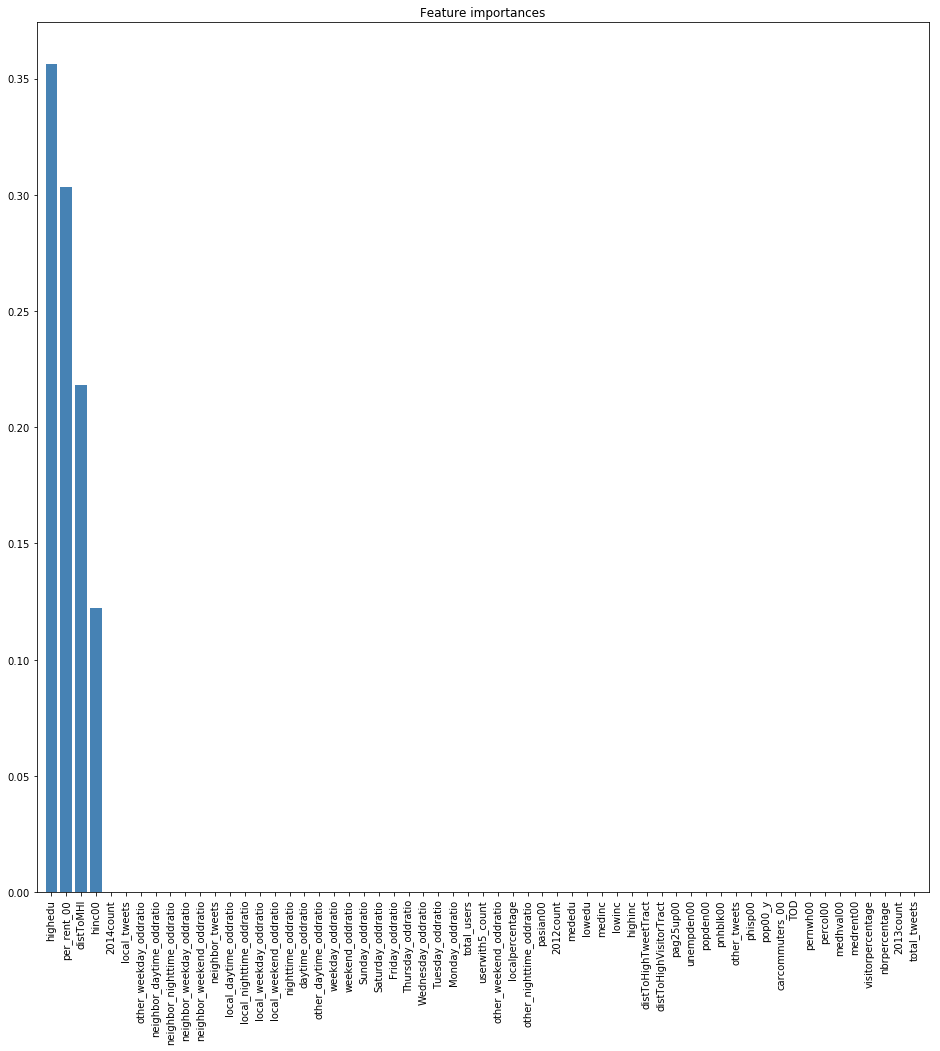

people2_target trainscore:  0.926335174954 testscore:  0.903329752954 F1:  0.521276595745 
 [[2666   97]
 [ 153  187]]


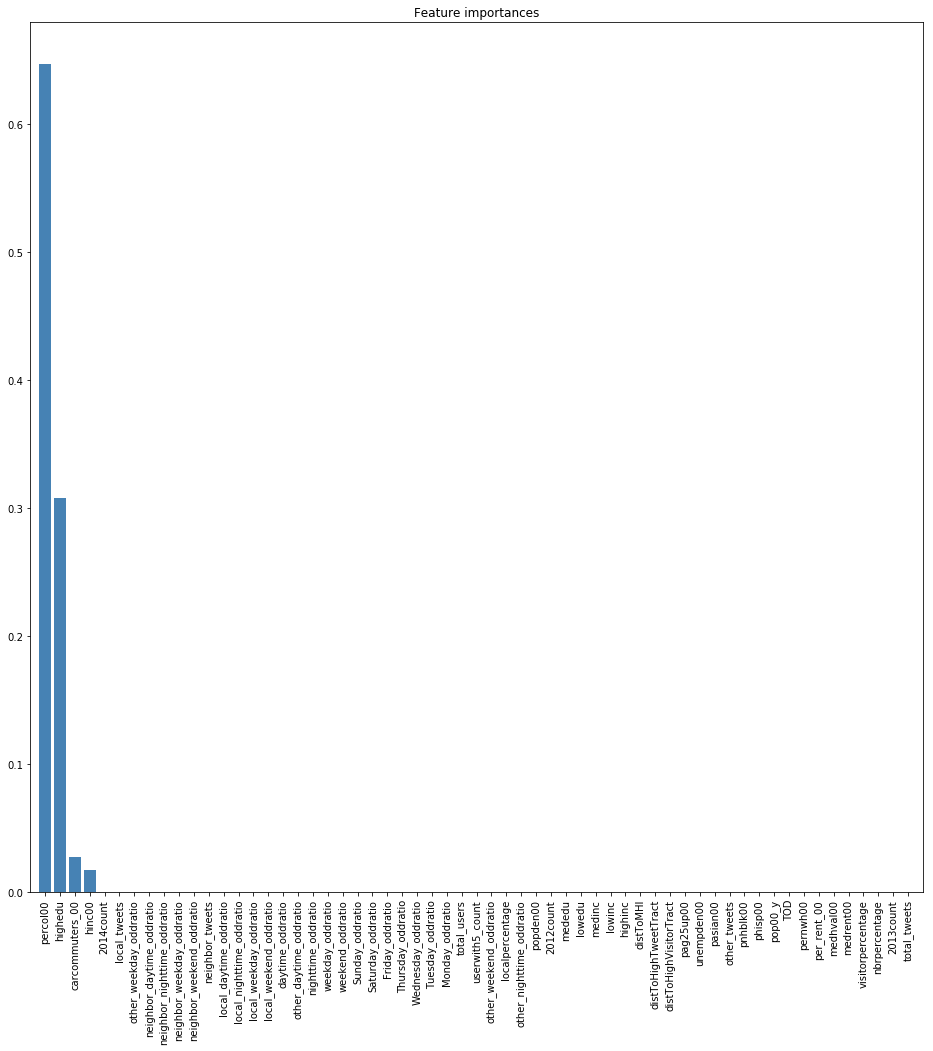

place1_target trainscore:  0.923572744015 testscore:  0.903329752954 F1:  0.210526315789 
 [[2795   16]
 [ 240   52]]


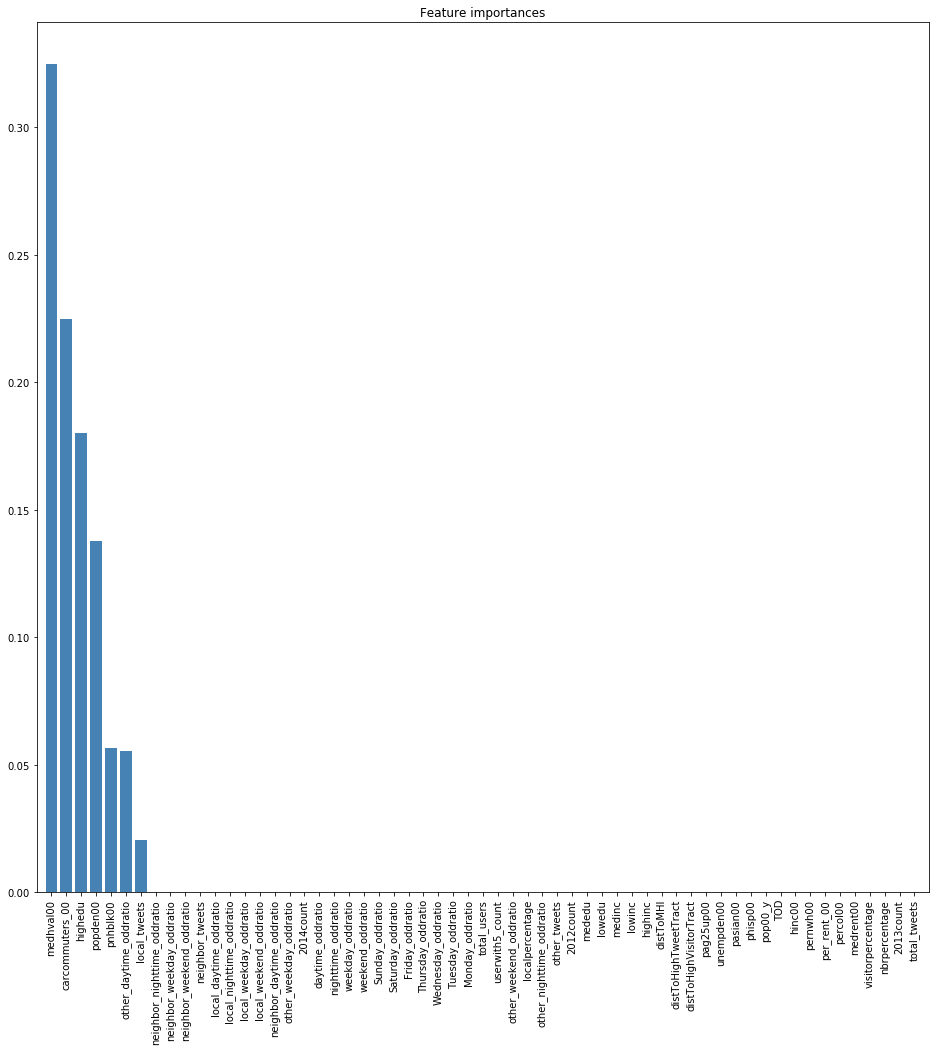

place2_target trainscore:  0.904696132597 testscore:  0.900107411386 F1:  0.290076335878 
 [[2714   48]
 [ 252   89]]


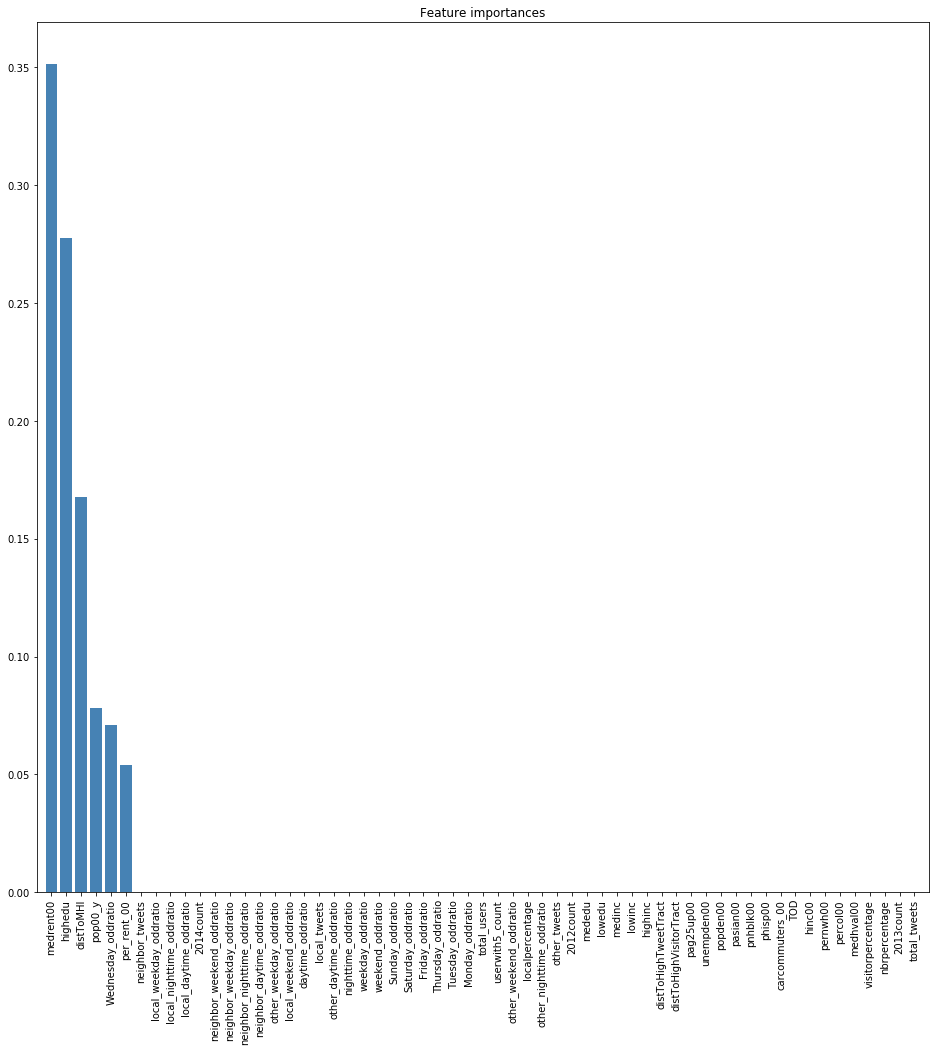

gent16_target trainscore:  0.945672191529 testscore:  0.933404940924 F1:  0.0 
 [[2918    2]
 [ 178    5]]


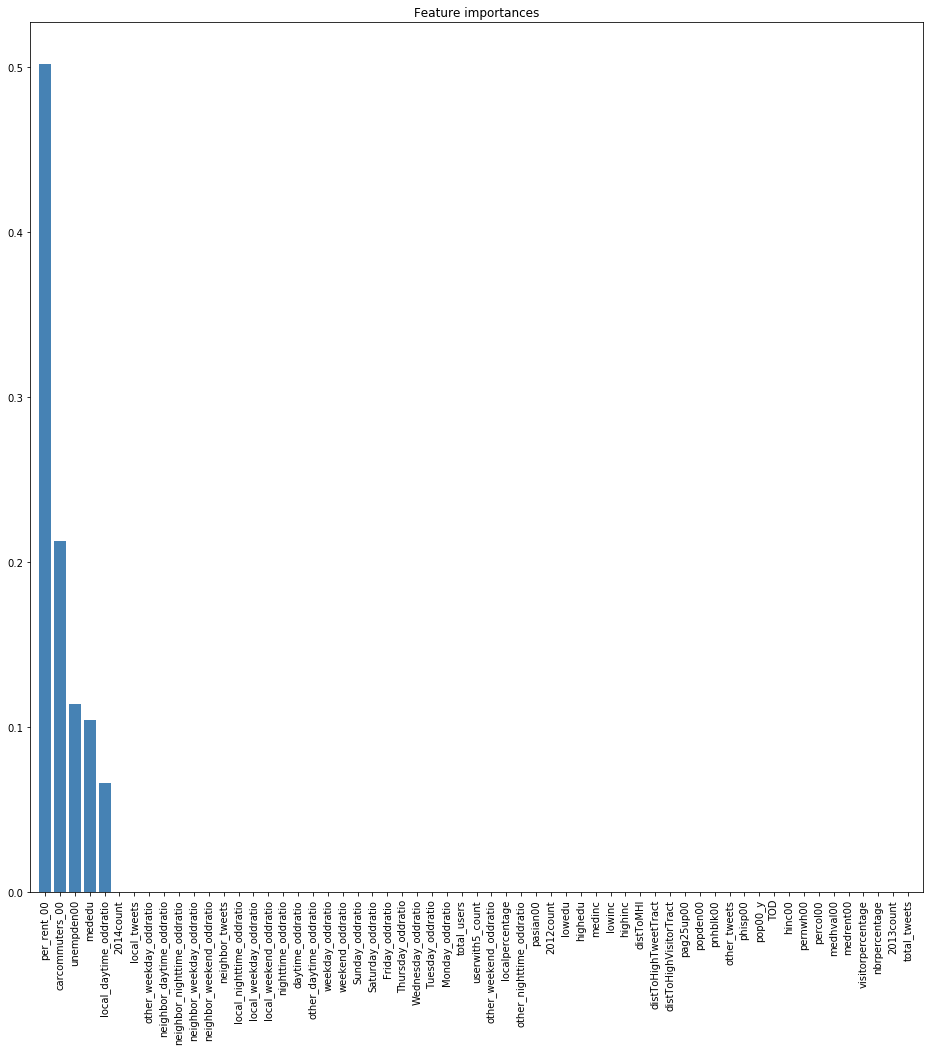

supergent_target trainscore:  0.993093922652 testscore:  0.988184747583 F1:  0.702702702703 
 [[3025   12]
 [  14   52]]


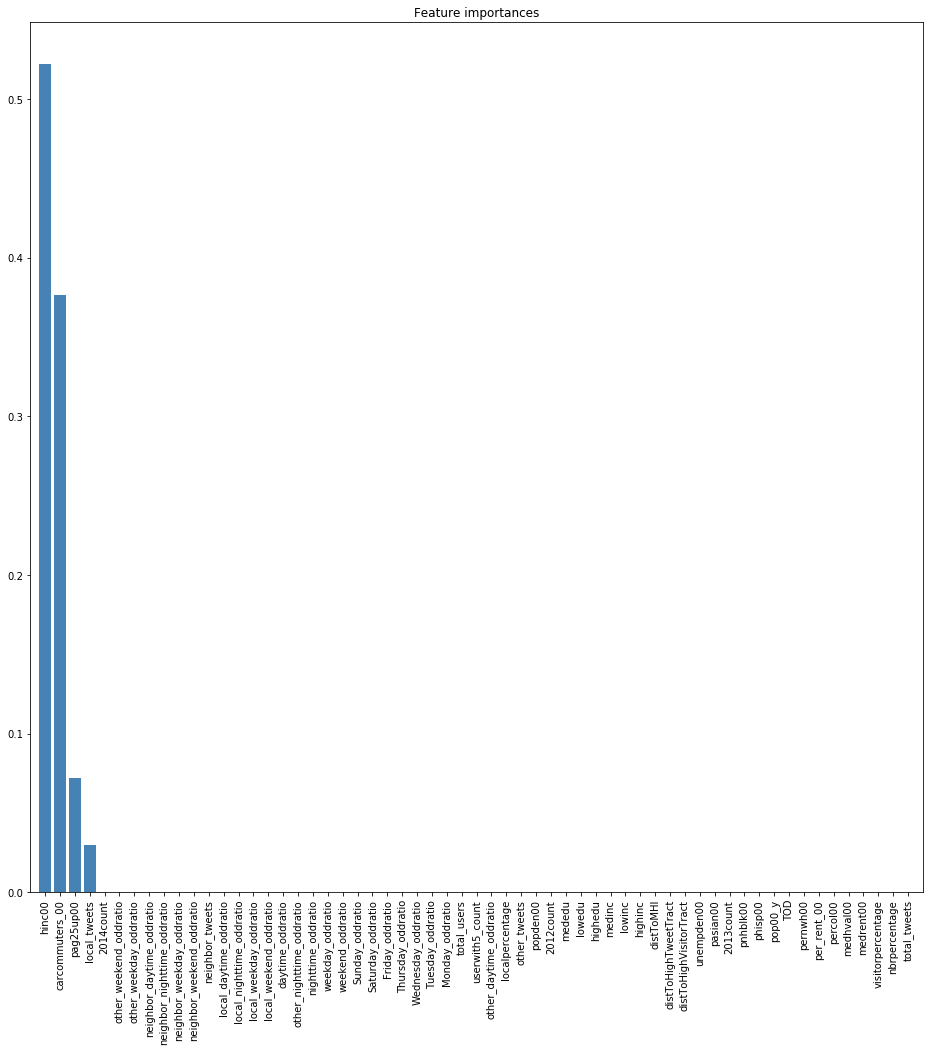

In [104]:
targetnames = ['binary', 'people_target', 'people2_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets6 = [alltwitter[['Type_binary']], alltwitter[['pct_ch_hinc00_16_binary']], alltwitter[['pct_ch_percol00_16_binary']],  alltwitter[['pct_ch_medhval00_16_binary']], alltwitter[['pct_ch_medrent00_16_binary']], alltwitter[['gent00_16_y']], alltwitter[['Supergent16']]]
alltwittermodeldata = alltwitter.iloc[:, 0:-7]
a=0 
alltwitterresdict = []
print('[TN, FP][FN, TP]')
for n in targets6: 
    modeldata6= alltwittermodeldata
    modeltarget6 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata6, modeltarget6, test_size = 0.3, random_state = 1)
    clf6 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf6.score(modeldata_train, modeltarget_train)
    testscore = clf6.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, clf6.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget6, clf6.predict(modeldata6)) )
    featureImportancePlot(clf6, modeldata6.columns)
    alltwitterresdict.append({'featureset': 'alltwitter', 'binaryvariable': targetnames[a], 'modeltype': 'DT', 'fscore': f1score})
    a += 1

In [105]:
#targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets6 = [alltwitter[['Type_binary']], alltwitter[['pct_ch_hinc00_16_binary']], alltwitter[['pct_ch_medhval00_16_binary']], alltwitter[['pct_ch_medrent00_16_binary']], alltwitter[['gent00_16_y']], alltwitter[['Supergent16']]]
alltwittermodeldata = alltwitter.iloc[:, 0:-7]
a=0 
print('[TN, FP][FN, TP]')
for n in targets6: 
    modeldata6= alltwittermodeldata
    modeltarget6 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata6, modeltarget6, test_size = 0.3, random_state = 1)
    logit_6 = LogisticRegression(C = 10000)
    logit_6.fit(modeldata_train, modeltarget_train)
    trainscore = logit_6.score(modeldata_train, modeltarget_train)
    testscore = logit_6.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, logit_6.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget6, logit_6.predict(modeldata6)) )
    #featureImportancePlot(clf4, modeldata4.columns)
    alltwitterresdict.append({'featureset': 'alltwitter', 'binaryvariable': targetnames[a], 'modeltype': 'logit', 'fscore': f1score})
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.876611418048 testscore:  0.84425349087 F1:  0.0 
 [[2683   13]
 [ 400    7]]
people_target trainscore:  0.839318600368 testscore:  0.871106337272 F1:  0.189189189189 
 [[2581   43]
 [ 426   53]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

people2_target trainscore:  0.890883977901 testscore:  0.896885069817 F1:  0.127272727273 
 [[2739   24]
 [ 309   31]]
place1_target trainscore:  0.911602209945 testscore:  0.897959183673 F1:  0.188034188034 
 [[2777   34]
 [ 253   39]]
place2_target trainscore:  0.889963167587 testscore:  0.888292158969 F1:  0.0 
 [[2753    9]
 [ 334    7]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

gent16_target trainscore:  0.943370165746 testscore:  0.93447905478 F1:  0.0 
 [[2919    1]
 [ 183    0]]
supergent_target trainscore:  0.975598526703 testscore:  0.979591836735 F1:  0.24 
 [[3023   14]
 [  58    8]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[TN, FP][FN, TP]
binary trainscore:  0.878913443831 testscore:  0.848549946294 F1:  0.0 
 [[2696    0]
 [ 404    3]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


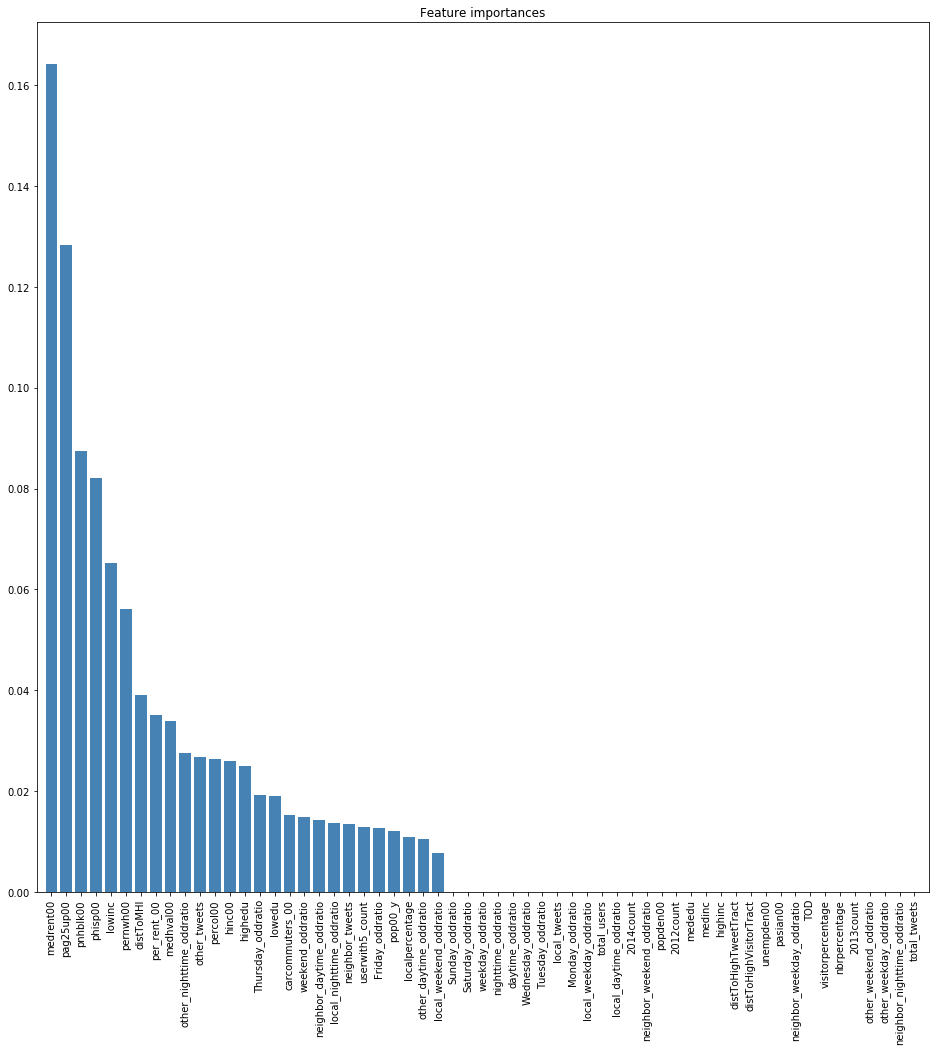

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


people_target trainscore:  0.843462246777 testscore:  0.877551020408 F1:  0.05 
 [[2620    4]
 [ 450   29]]


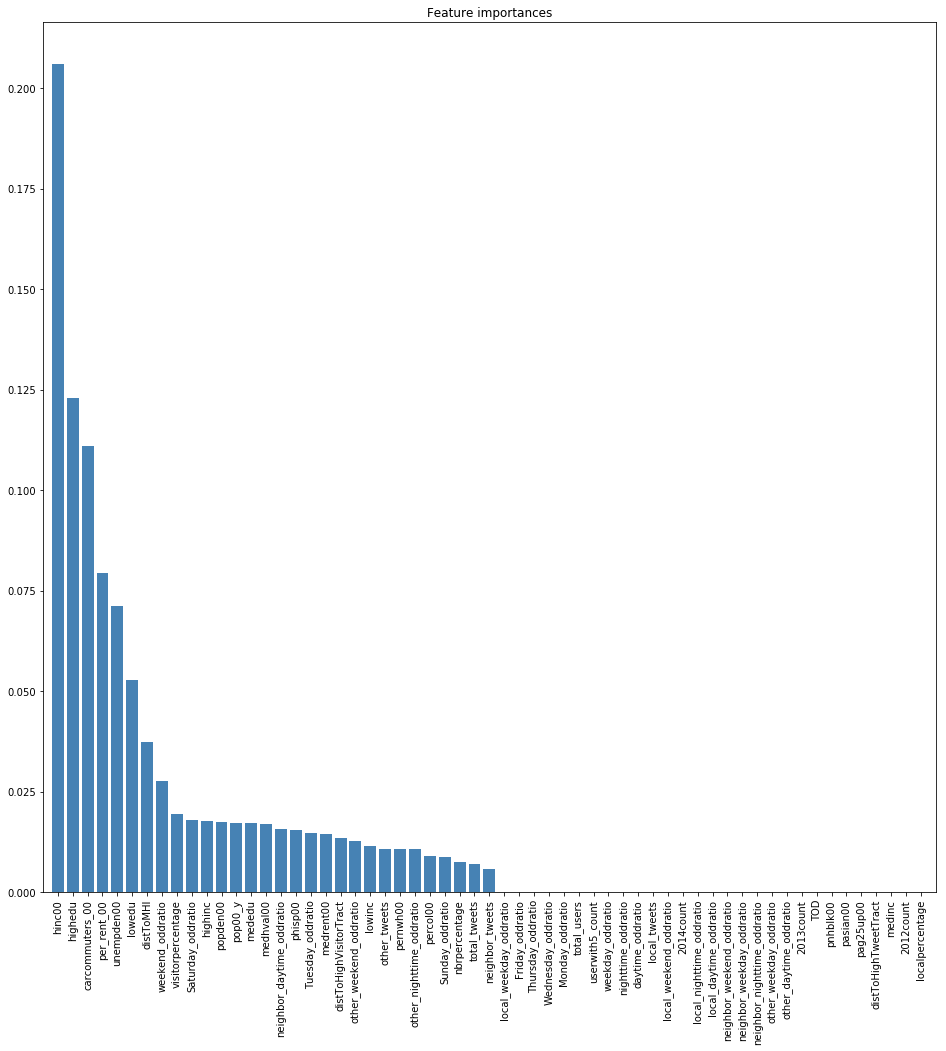

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


people2_target trainscore:  0.901473296501 testscore:  0.90440386681 F1:  0.168224299065 
 [[2758    5]
 [ 298   42]]


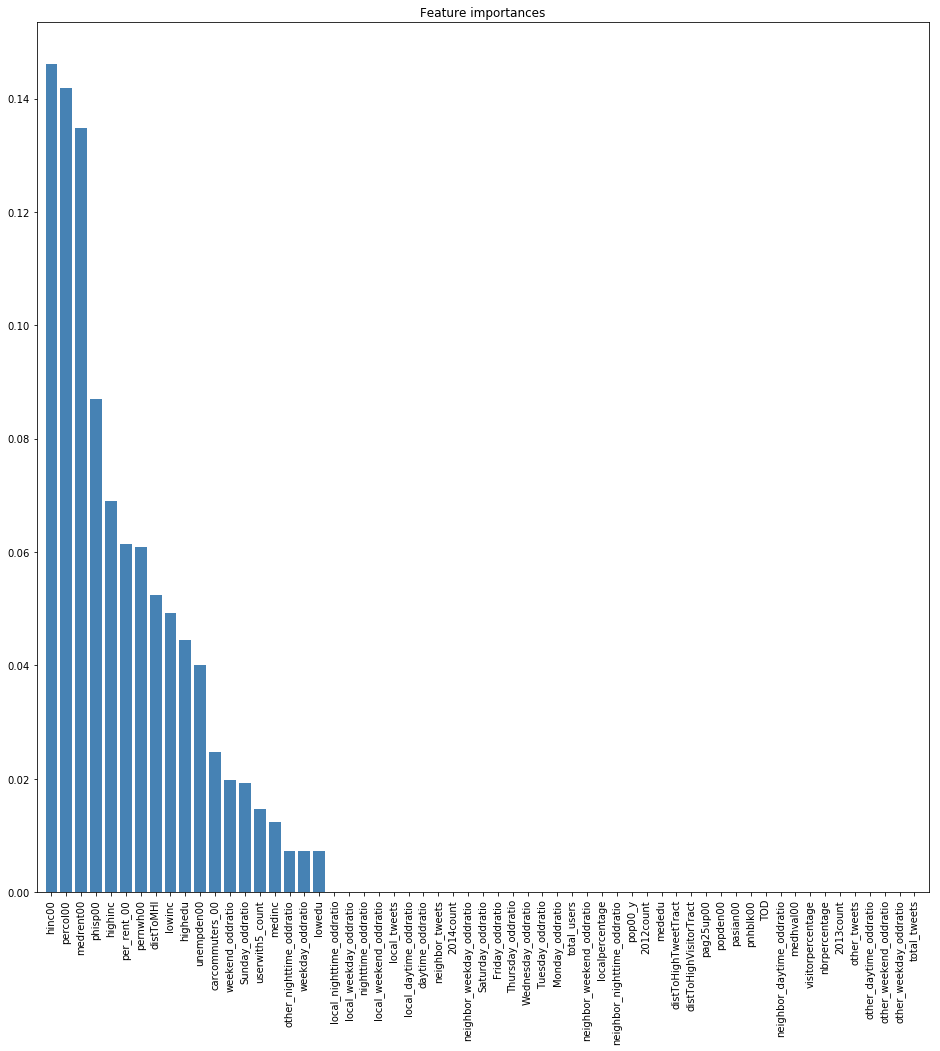

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


place1_target trainscore:  0.909300184162 testscore:  0.900107411386 F1:  0.0210526315789 
 [[2811    0]
 [ 290    2]]


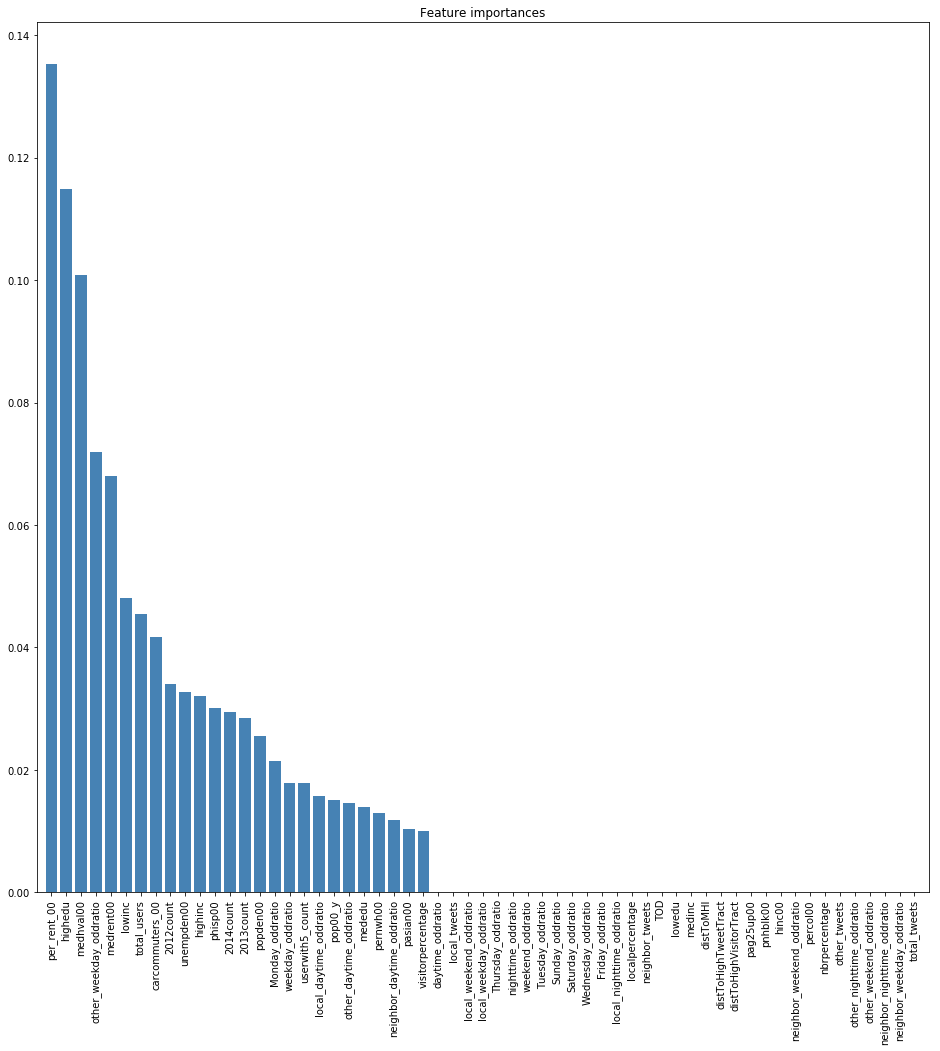

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


place2_target trainscore:  0.89364640884 testscore:  0.892588614393 F1:  0.0 
 [[2762    0]
 [ 331   10]]


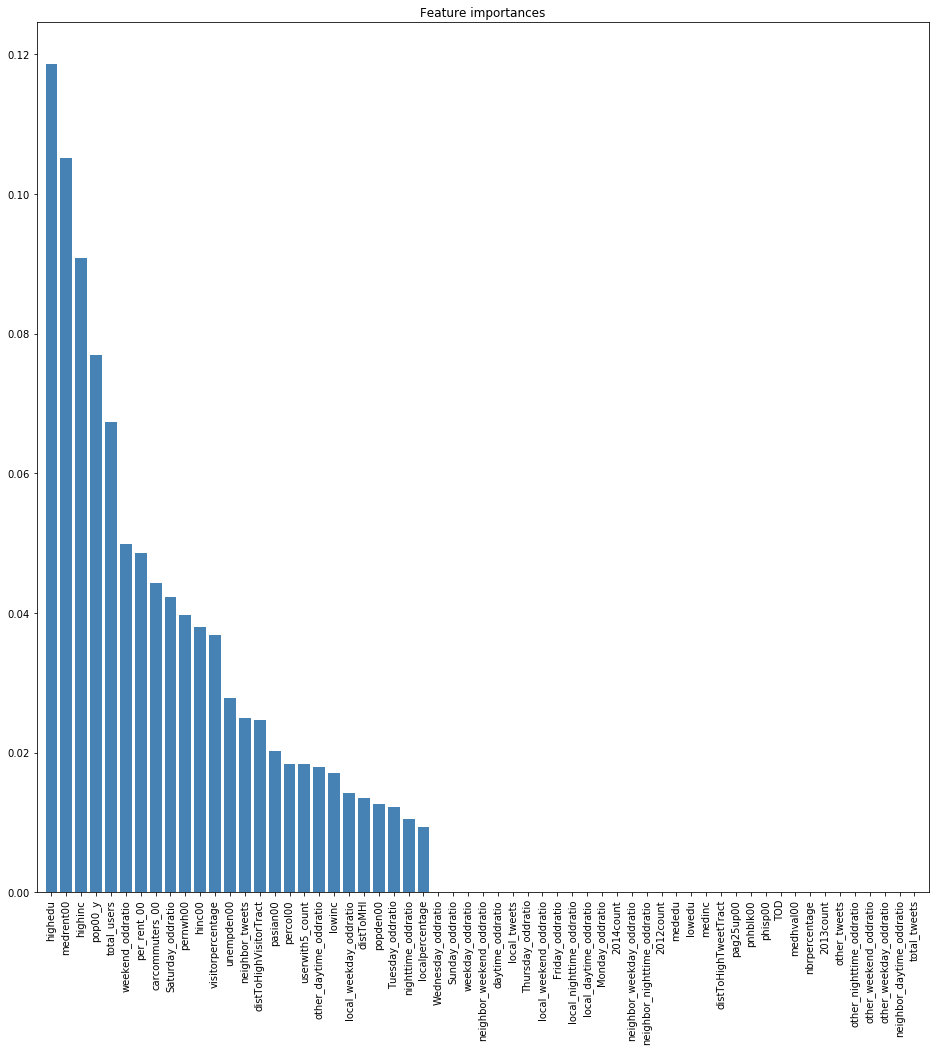

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


gent16_target trainscore:  0.943370165746 testscore:  0.935553168636 F1:  0.0 
 [[2920    0]
 [ 183    0]]


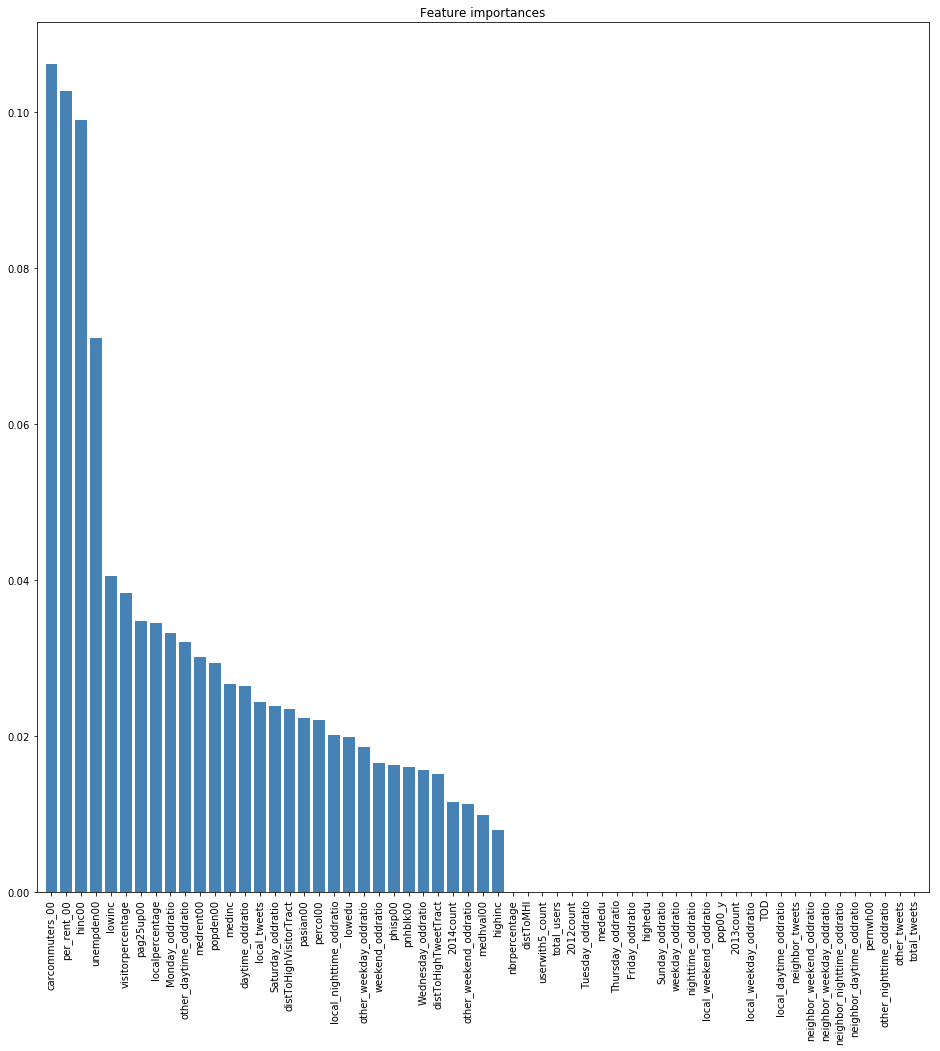

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


supergent_target trainscore:  0.98802946593 testscore:  0.978517722879 F1:  0.285714285714 
 [[3032    5]
 [  41   25]]


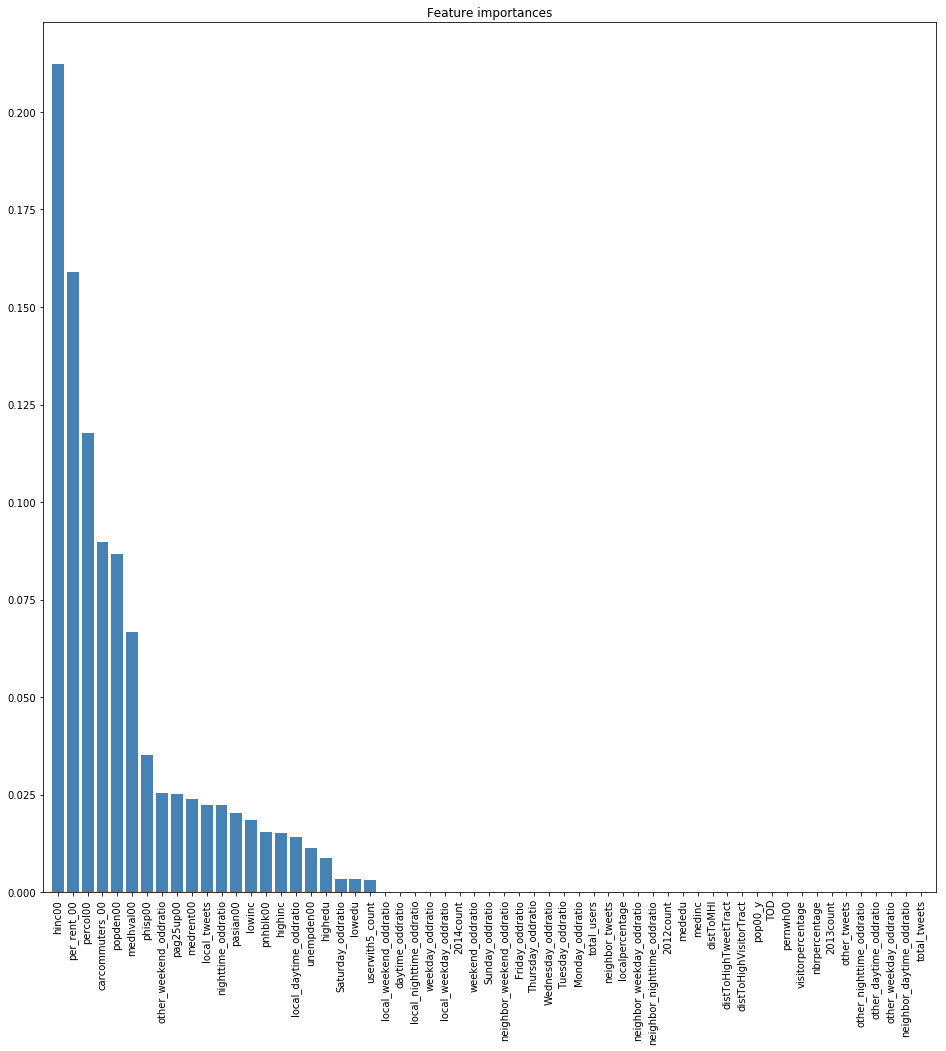

In [106]:
#targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets6 = [alltwitter[['Type_binary']], alltwitter[['pct_ch_hinc00_16_binary']], alltwitter[['pct_ch_medhval00_16_binary']], alltwitter[['pct_ch_medrent00_16_binary']], alltwitter[['gent00_16_y']], alltwitter[['Supergent16']]]
alltwittermodeldata = alltwitter.iloc[:, 0:-7]
a=0 
seed = 5
print('[TN, FP][FN, TP]')
for n in targets6: 
    modeldata6= alltwittermodeldata
    modeltarget6 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata6, modeltarget6, test_size = 0.3, random_state = 1)
    rf6=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf6 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf6.fit(modeldata_train, modeltarget_train)
    trainscore = rf6.score(modeldata_train, modeltarget_train)
    testscore = rf6.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget_test, rf6.predict(modeldata_test))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget6, rf6.predict(modeldata6)) )
    featureImportancePlot(rf6, modeldata6.columns)
    alltwitterresdict.append({'featureset': 'alltwitter', 'binaryvariable': targetnames[a], 'modeltype': 'RF', 'fscore': f1score})
    a += 1

In [107]:
resultsdf = resultsdf.append(alltwitterresdict)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [108]:
resultsdf.to_csv('Data/newresults0723.csv')

In [109]:
resultsdf

,binaryvariable,f1score,featureset,fscore,modeltype
0,NaN,NaN,NaN,NaN,NaN
0,binary,NaN,censusonly,0.000000,DT
1,people_target,NaN,censusonly,0.012422,DT
2,people2_target,NaN,censusonly,0.285714,DT
3,place1_target,NaN,censusonly,0.288288,DT
4,place2_target,NaN,censusonly,0.000000,DT
5,gent16_target,NaN,censusonly,0.388350,DT
6,supergent_target,NaN,censusonly,0.634146,DT
7,binary,NaN,censusonly,0.024390,logit
8,people_target,NaN,censusonly,0.180851,logit
